<a href="https://colab.research.google.com/github/mjrakmad/MDS210_BigDataProject/blob/main/BIG_DATA_FINALCODE_Akmad_Kintanar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/mjrakmad/MDS210_BigDataProject/blob/main/BIG_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Air Quality Data in Cotabato City Using Spark**

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **LIBRARIES**

In [66]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [67]:
sparkSession = SparkSession.builder.appName('bigdata').getOrCreate()

In [68]:
df_pyspark = sparkSession.read.csv('/content/drive/MyDrive/Dataset/CotabatoCity_AQMS.csv',
    header=True,
    inferSchema=True
)

## **DATA CLEANING**

In [69]:

# Print Schema
df_pyspark.printSchema()

# Print Dataframe
df_pyspark.show()

root
 |-- Date and Time: string (nullable = true)
 |-- Wind Speed: double (nullable = true)
 |-- Wind Direction: double (nullable = true)
 |-- Barometric Pressure: double (nullable = true)
 |-- Ambient Humidity: double (nullable = true)
 |-- Ambient Temperature: double (nullable = true)
 |-- Solar Radiation: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- PM10 Concentration: double (nullable = true)
 |-- PM25 Concentration: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- SO2: string (nullable = true)
 |-- CO: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- PM10 AQI: integer (nullable = true)
 |-- PM25 AQI: integer (nullable = true)
 |-- NO2 Index: integer (nullable = true)
 |-- SO2 Index: string (nullable = true)
 |-- CO Index: string (nullable = true)
 |-- O3 Index: string (nullable = true)
 |-- AQI Index: integer (nullable = true)

+----------------+----------+-

In [70]:
df_pyspark.describe().show()

+-------+----------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+--------------------+-----------------+
|summary|   Date and Time|        Wind Speed|    Wind Direction|Barometric Pressure|  Ambient Humidity|Ambient Temperature|   Solar Radiation|           Rainfall|PM10 Concentration|PM25 Concentration|                NO|               NO2|               NOX|               SO2|                CO|                 O3|          PM10 AQI|         PM25 AQI|         NO2 Index|         SO2 Index|         CO Index|            O3 Index|        AQI Index|
+-------+----------------+------------------+------------------+-------------------+------------------+-

There are values with negative that should not be below 0. There are also null values

Ambient Temperature: -246.6

Rainfall : -93.4

Ozone (O3) has negative values

In [71]:
from pyspark.sql.functions import col, isnan, when, count

# Count missing values (null or NaN) for each column in df_pyspark
missing_values = df_pyspark.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark.columns]
)

missing_values.show()

+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+----+---+---+--------+--------+---------+---------+--------+--------+---------+
|Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2|NOX| SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|
+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+----+---+---+--------+--------+---------+---------+--------+--------+---------+
|            0|         0|             0|                  0|               0|                  0|              0|       0|                 0|                 0|  0|  0|  0|1098|  0|  0|       0|       0|        0|     1098|       0|       0

There are null or missing values for the SO2 and So2 index

**DATA IMPUTATION**

In [72]:
from pyspark.sql.functions import col, mean

# Step 1: Convert columns to numeric (DoubleType) if necessary
df_pyspark = df_pyspark.withColumn("SO2", col("SO2").cast("double"))
df_pyspark = df_pyspark.withColumn("SO2 Index", col("SO2 Index").cast("double"))
df_pyspark = df_pyspark.withColumn("CO Index", col("CO Index").cast("double"))
df_pyspark = df_pyspark.withColumn("O3 Index", col("O3 Index").cast("double"))

# Step 2: Calculate means for columns with missing values
mean_values = df_pyspark.select(
    mean("SO2").alias("SO2_mean"),
    mean("SO2 Index").alias("SO2_Index_mean"),
    mean("CO Index").alias("CO_Index_mean"),
    mean("O3 Index").alias("O3_Index_mean")
).collect()[0]

# Extract the mean values
so2_mean = mean_values["SO2_mean"]
so2_index_mean = mean_values["SO2_Index_mean"]
co_index_mean = mean_values["CO_Index_mean"]
o3_index_mean = mean_values["O3_Index_mean"]

# Step 3: Impute missing values with the computed means
df_pyspark_imputed = df_pyspark.fillna({
    "SO2": so2_mean,
    "SO2 Index": so2_index_mean,
    "CO Index": co_index_mean,
    "O3 Index": o3_index_mean
})

# Step 4: Show the resulting DataFrame
df_pyspark_imputed.show()

+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+------------------+---+---+--------+--------+---------+------------------+--------+--------+---------+
|   Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|               SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|         SO2 Index|CO Index|O3 Index|AQI Index|
+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+------------------+---+---+--------+--------+---------+------------------+--------+--------+---------+
|26/12/2024 13:00|       1.6|         142.8|             1019.7|            59.3|               33.2|          607.6|     0.0|              24.0|               

In [73]:
df_pyspark.describe().show()

+-------+----------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+--------------------+-----------------+
|summary|   Date and Time|        Wind Speed|    Wind Direction|Barometric Pressure|  Ambient Humidity|Ambient Temperature|   Solar Radiation|           Rainfall|PM10 Concentration|PM25 Concentration|                NO|               NO2|               NOX|               SO2|                CO|                 O3|          PM10 AQI|         PM25 AQI|         NO2 Index|         SO2 Index|         CO Index|            O3 Index|        AQI Index|
+-------+----------------+------------------+------------------+-------------------+------------------+-

Text(0, 0.5, 'Frequency')

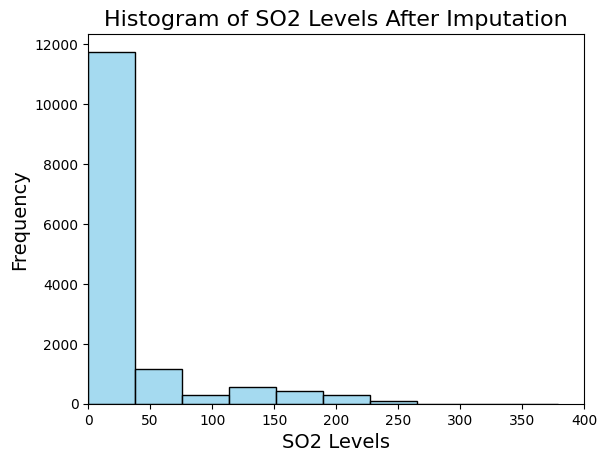

In [74]:
imputed_data = df_pyspark_imputed.select("SO2", "SO2 Index").toPandas()

# Plot histogram for SO2
plt.xlim(0, 400)  # Set x-axis limits
sns.histplot(imputed_data["SO2"], bins=10, kde=False, color="skyblue")
plt.title("Histogram of SO2 Levels After Imputation", fontsize=16)
plt.xlabel("SO2 Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

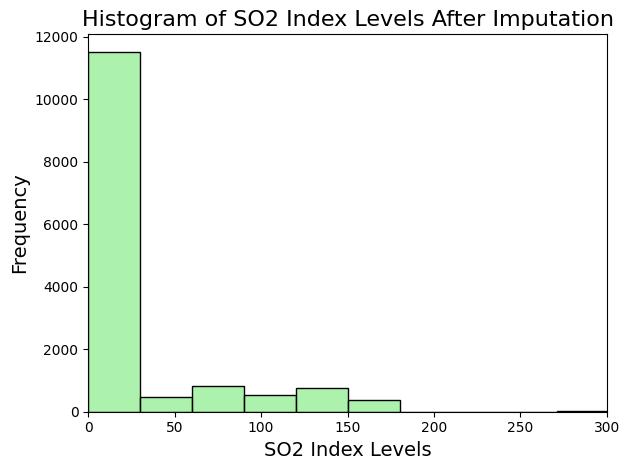

In [75]:
# Plot histogram for SO2 Index
plt.xlim(0, 300)  # Set x-axis limits
sns.histplot(imputed_data["SO2 Index"], bins=10, kde=False, color="lightgreen")
plt.title("Histogram of SO2 Index Levels After Imputation", fontsize=16)
plt.xlabel("SO2 Index Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

**Imputing the negative values of Temperature, Rainfall and Ozone (O3)**

In [76]:
from pyspark.sql.functions import when, col, mean

# Step 1: Ensure the columns are of type DoubleType
df_pyspark = df_pyspark.withColumn("Ambient Temperature", col("Ambient Temperature").cast("double"))
df_pyspark = df_pyspark.withColumn("Rainfall", col("Rainfall").cast("double"))
df_pyspark = df_pyspark.withColumn("O3", col("O3").cast("double"))

# Step 2: Calculate means for the columns
mean_values = df_pyspark.select(
    mean("Ambient Temperature").alias("Ambient_Temperature_mean"),
    mean("Rainfall").alias("Rainfall_mean"),
    mean("O3").alias("O3_mean")
).collect()[0]

# Extract the mean values
ambient_temperature_mean = mean_values["Ambient_Temperature_mean"]
rainfall_mean = mean_values["Rainfall_mean"]
o3_mean = mean_values["O3_mean"]

# Step 3: Replace negative values with the respective mean
df_pyspark_replaced = df_pyspark.withColumn(
    "Ambient Temperature",
    when(col("Ambient Temperature") < 0, ambient_temperature_mean).otherwise(col("Ambient Temperature"))
).withColumn(
    "Rainfall",
    when(col("Rainfall") < 0, rainfall_mean).otherwise(col("Rainfall"))
).withColumn(
    "O3",
    when(col("O3") < 0, o3_mean).otherwise(col("O3"))
)

# Step 4: Validate the replacements
df_pyspark_replaced.describe().show()

+-------+----------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+--------------------+-----------------+
|summary|   Date and Time|        Wind Speed|    Wind Direction|Barometric Pressure|  Ambient Humidity|Ambient Temperature|   Solar Radiation|           Rainfall|PM10 Concentration|PM25 Concentration|                NO|               NO2|               NOX|               SO2|                CO|                 O3|          PM10 AQI|         PM25 AQI|         NO2 Index|         SO2 Index|         CO Index|            O3 Index|        AQI Index|
+-------+----------------+------------------+------------------+-------------------+------------------+-

## **OUTLIERS REMOVAL**

In [77]:
# prompt: Replace the outliers with the median for the df_pyspark_imputed

from pyspark.sql.functions import when, col, lit

def remove_outliers_with_median(df, column_name):
    # Calculate quantiles
    quantile1 = df.approxQuantile(column_name, [0.25], 0.0)[0]
    quantile3 = df.approxQuantile(column_name, [0.75], 0.0)[0]

    # Calculate IQR
    iqr = quantile3 - quantile1

    # Calculate lower and upper bounds
    lower_bound = quantile1 - 1.5 * iqr
    upper_bound = quantile3 + 1.5 * iqr

    # Calculate the median
    median = df.approxQuantile(column_name, [0.5], 0.0)[0]

    # Replace outliers with the median
    df = df.withColumn(
        column_name,
        when((col(column_name) < lower_bound) | (col(column_name) > upper_bound), median).otherwise(col(column_name))
    )
    return df

# Apply outlier removal to SO2 and SO2 Index columns
df_pyspark_imputed = remove_outliers_with_median(df_pyspark_imputed, "SO2")
df_pyspark_imputed = remove_outliers_with_median(df_pyspark_imputed, "SO2 Index")

# Display the updated DataFrame
df_pyspark_imputed.show()

+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+------------------+---+---+--------+--------+---------+------------------+--------+--------+---------+
|   Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|               SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|         SO2 Index|CO Index|O3 Index|AQI Index|
+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+------------------+---+---+--------+--------+---------+------------------+--------+--------+---------+
|26/12/2024 13:00|       1.6|         142.8|             1019.7|            59.3|               33.2|          607.6|     0.0|              24.0|               

In [78]:
# checking missing values again
from pyspark.sql.functions import col, isnan, when, count

# Count missing values (null or NaN) for each column in df_pyspark
missing_values = df_pyspark_imputed.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark_imputed.columns]
)

missing_values.show()

+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2|NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|
+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|            0|         0|             0|                  0|               0|                  0|              0|       0|                 0|                 0|  0|  0|  0|  0|  0|  0|       0|       0|        0|        0|       0|       0|   

## **FEATURE EXTRACTION**

In [79]:
from pyspark.sql.functions import date_format, to_timestamp

# Step 1: Convert "Date and Time" column to TimestampType if not already
df_pyspark = df_pyspark_imputed.withColumn("Date and Time", to_timestamp("Date and Time", "dd/MM/yyyy HH:mm"))

# Step 2: Extract the day
df_pyspark = df_pyspark.withColumn("Day", date_format("Date and Time", "dd"))

# Step 3: Extract the hour
df_pyspark = df_pyspark.withColumn("Hour", date_format("Date and Time", "HH"))

# Step 4: Extract the month
df_pyspark = df_pyspark.withColumn("Month", date_format("Date and Time", "MM"))

# Step 5: Extract the day of the week
df_pyspark = df_pyspark.withColumn("DayOfWeek", date_format("Date and Time", "EEEE"))

# Show the updated DataFrame
df_pyspark.show()

+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+------------------+---+---+--------+--------+---------+------------------+--------+--------+---------+---+----+-----+---------+
|      Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|               SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|         SO2 Index|CO Index|O3 Index|AQI Index|Day|Hour|Month|DayOfWeek|
+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+------------------+---+---+--------+--------+---------+------------------+--------+--------+---------+---+----+-----+---------+
|2024-12-26 13:00:00|       1.6|         142.8|             1019.7|         

In [80]:
from pyspark.sql.functions import when

def categorize_aqi(aqi_value):
  # Use when and otherwise for conditional logic within the PySpark DataFrame context
  return when(aqi_value <= 50, "Good").\
         when(aqi_value <= 100, "Moderate").\
         when(aqi_value <= 150, "Unhealthy for Sensitive Groups").\
         when(aqi_value <= 200, "Unhealthy").\
         when(aqi_value <= 300, "Very Unhealthy").\
         otherwise("Hazardous")


df_pyspark = df_pyspark.withColumn("AQI_Category", categorize_aqi(col("AQI Index")))

df_pyspark.show()

+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+------------------+---+---+--------+--------+---------+------------------+--------+--------+---------+---+----+-----+---------+--------------------+
|      Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|               SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|         SO2 Index|CO Index|O3 Index|AQI Index|Day|Hour|Month|DayOfWeek|        AQI_Category|
+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+------------------+---+---+--------+--------+---------+------------------+--------+--------+---------+---+----+-----+---------+--------------------+
|2024-12-26 1

## **Visualization**


**Result:**

Cleaned and standardized datasets for variables such as pollutant concentrations, AQI indices, and meteorological data.

Basic statistics (mean, median, variance) for pollutant concentrations calculated.

Identified correlations among pollutants and environmental variables.

**Visualization**

* Correlation Heatmap: A heatmap displaying correlations between variables like PM10, PM25, SO2, and Wind Speed.
*   Boxplots: Boxplot for pollutants concentrations to identify outliers and assess the distribution. For example, monthly PM10 Concentration.


**Result:**

Temporal Trends: Identified daily, hourly, and seasonal patterns in air quality.

Pollutant Hotspots: Determined periods with high pollutant levels (e.g., rush hours for PM10).

Health Risk Analysis: Categorized AQI into health risk levels (Good, Moderate, Unhealthy, etc.).

**Visualization For Trends and Patterns**


*   Line Charts for Temporal Trends
*   Heatmaps for Hourly Patterns
Bar Charts for AQI Categories
Scatter Plots for Relationships

**FINAL DASHBOARD for Stakeholders**

Goal: Provide actionable insights in a centralized format.

Dashboard Components:

Real-time AQI Trends: Display current air quality indices and categories.

Seasonal Summary: Line charts for pollutant trends over months.

Policy Recommendations: A summary card highlighting peak pollution times and contributing factors.













**CORRELATION HEATMAP**

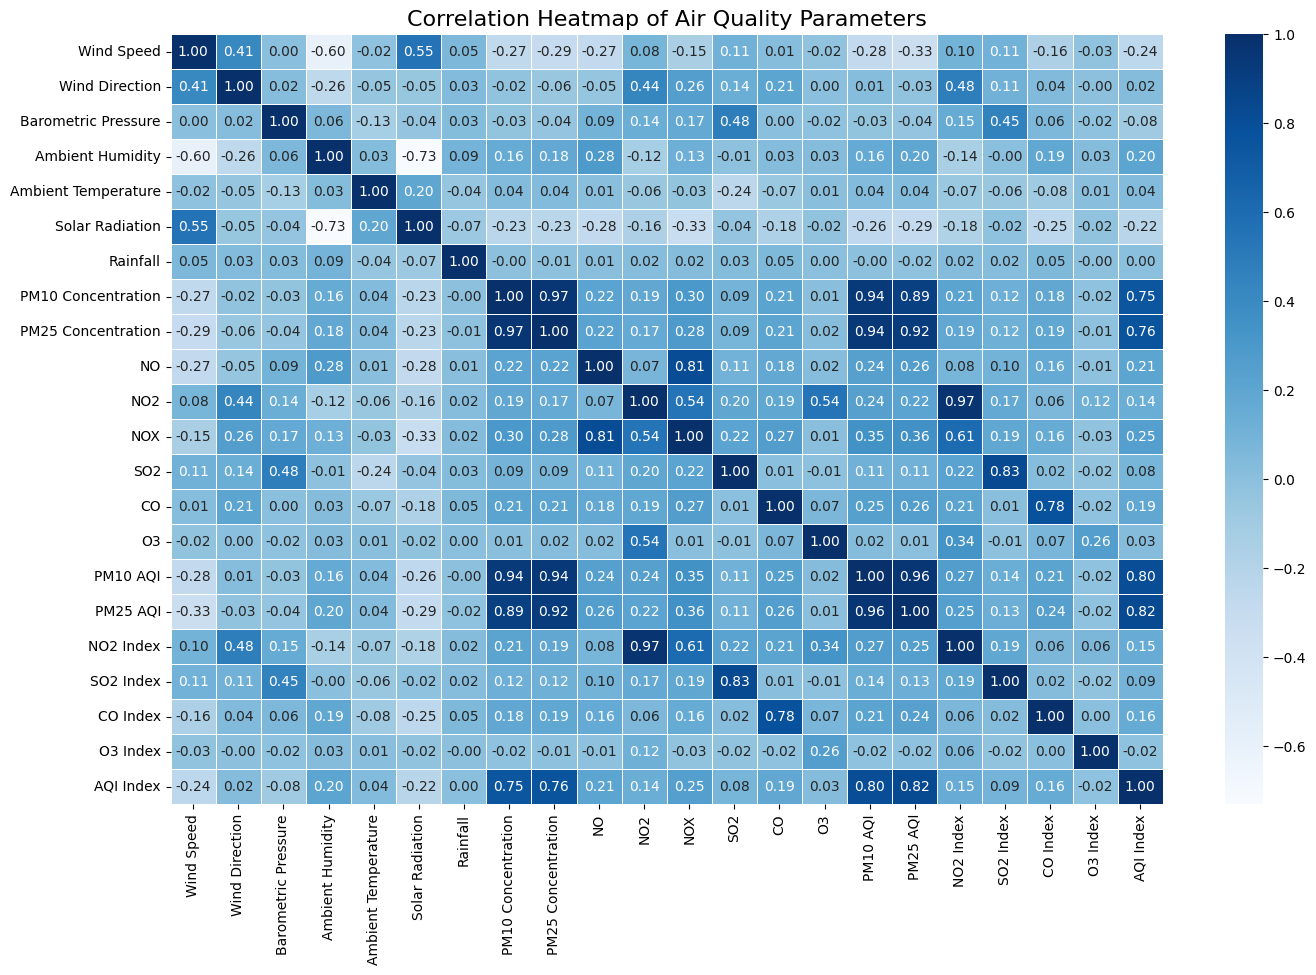

In [81]:
pandas_df = df_pyspark.toPandas()
columns_for_heatmap = ['Wind Speed', 'Wind Direction', 'Barometric Pressure',
                       'Ambient Humidity', 'Ambient Temperature', 'Solar Radiation',
                       'Rainfall', 'PM10 Concentration', 'PM25 Concentration', 'NO',
                       'NO2', 'NOX', 'SO2', 'CO', 'O3', 'PM10 AQI', 'PM25 AQI',
                       'NO2 Index', 'SO2 Index', 'CO Index', 'O3 Index', 'AQI Index']

pandas_df[columns_for_heatmap] = pandas_df[columns_for_heatmap].replace('NULL', pd.NA).apply(pd.to_numeric, errors='coerce')

correlation_matrix = pandas_df[columns_for_heatmap].corr()


plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Air Quality Parameters', fontsize=16)
plt.show()

**BOXPLOTS ON POLLUTANT CONCENTRATIONS**

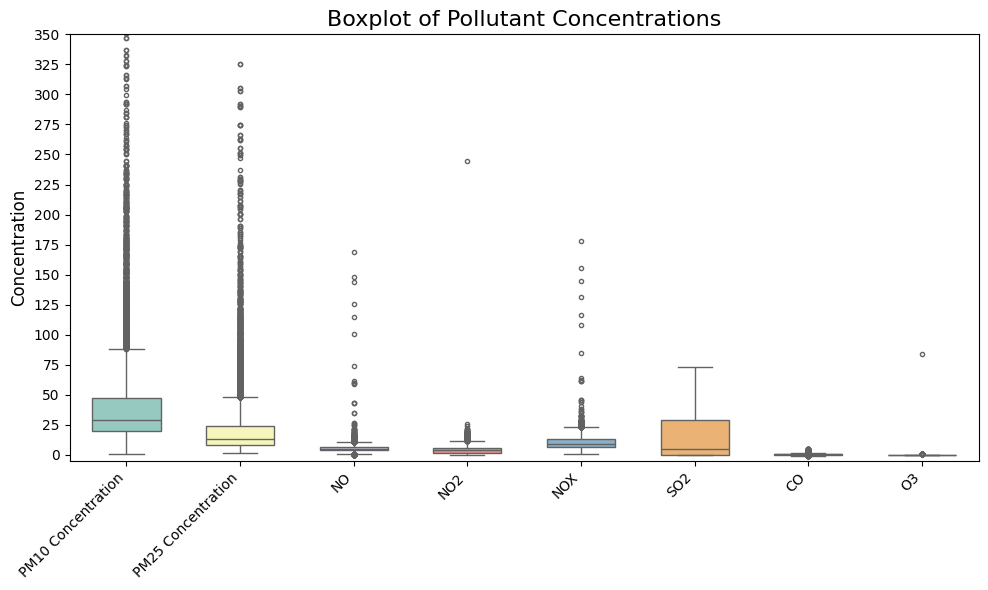

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'pandas_df' is your Pandas DataFrame (from previous code)
pollutants = ['PM10 Concentration', 'PM25 Concentration', 'NO', 'NO2', 'NOX', 'SO2', 'CO', 'O3']

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.boxplot(data=pandas_df[pollutants], palette="Set3", width=0.6, fliersize=3) # Added color and adjusted width
plt.ylim(-5, 350) # Set the y limit
plt.title('Boxplot of Pollutant Concentrations', fontsize=16)
plt.ylabel('Concentration', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout() # Adjust layout for better visualization
plt.yticks(np.arange(0, 351, 25))
plt.show()

# **Temporal Trends (Monthly, Daily, Hourly)**

**Month vs. Meteorological Factors**

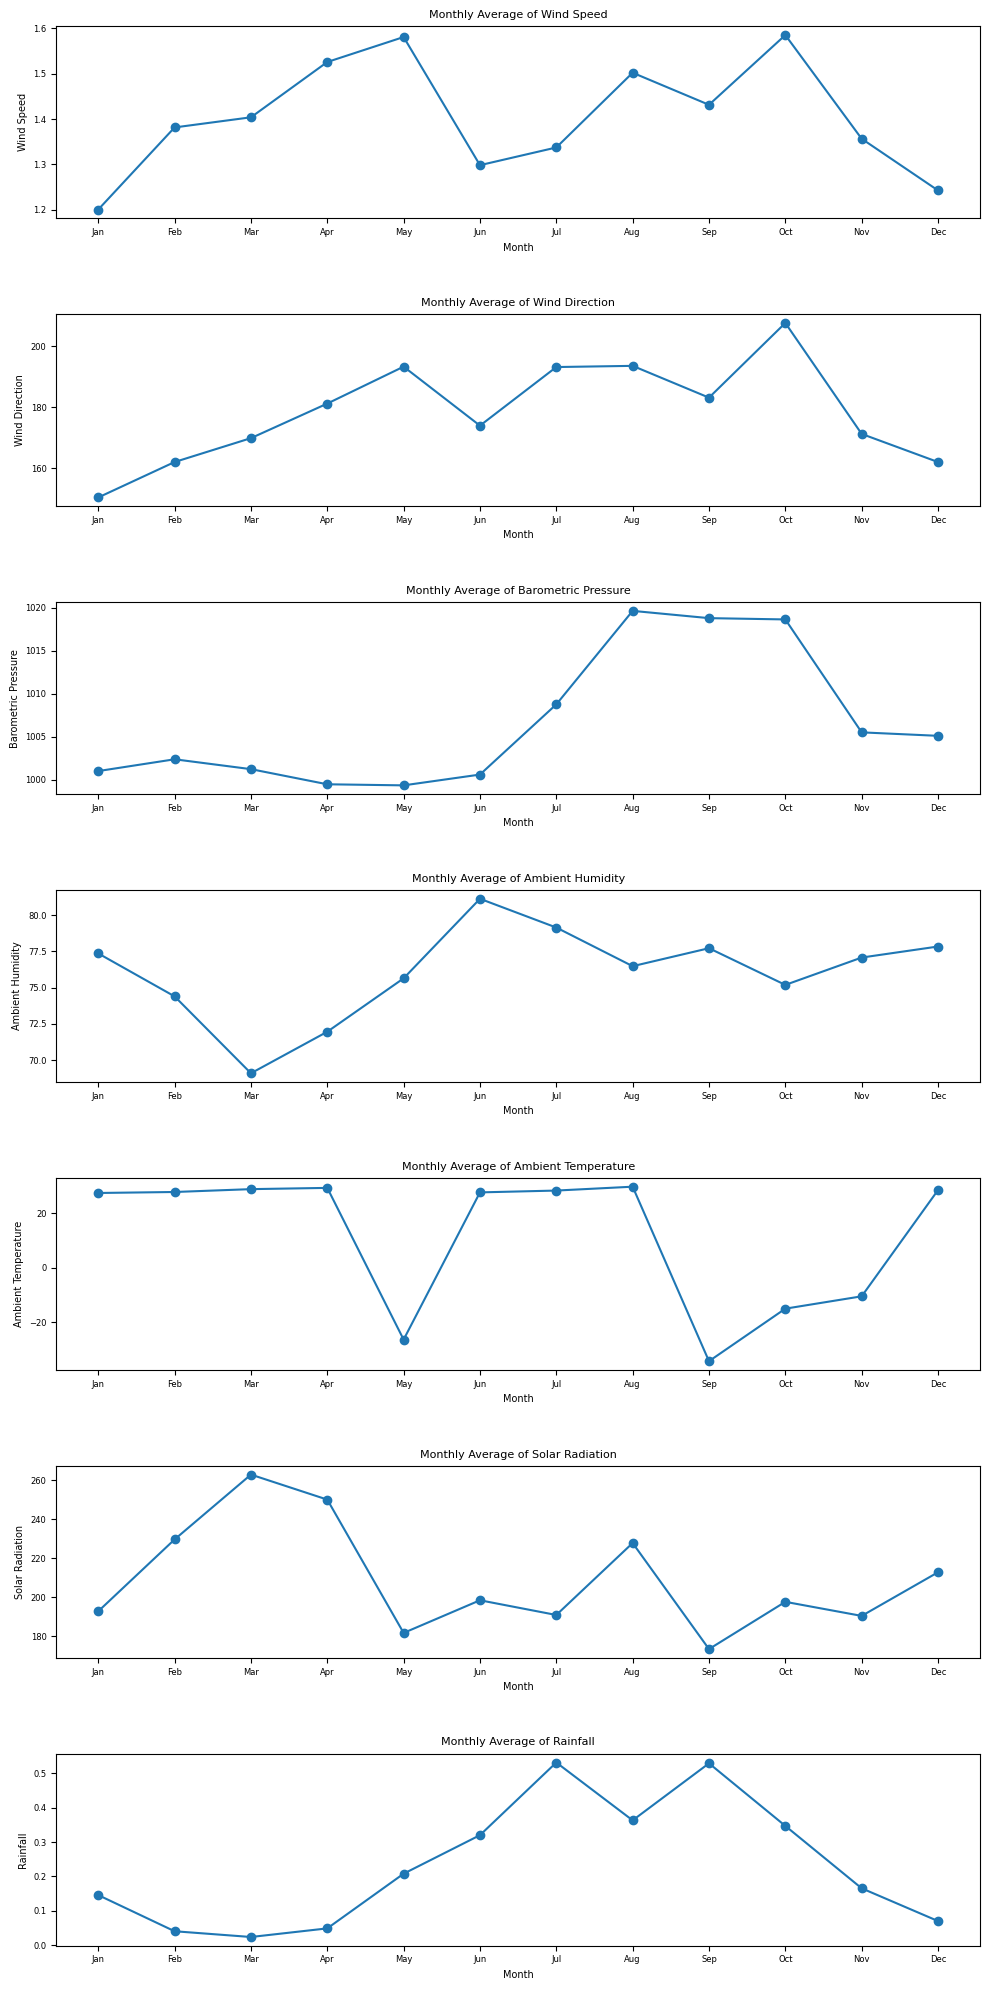

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'pandas_df' is your Pandas DataFrame and 'Month' column exists
variables = ['Wind Speed', 'Wind Direction', 'Barometric Pressure',
             'Ambient Humidity', 'Ambient Temperature', 'Solar Radiation',
             'Rainfall']

# Convert 'Month' column to numeric if it's not already
pandas_df['Month'] = pd.to_numeric(pandas_df['Month'], errors='coerce')

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 20), dpi=100)  # Adjust figure size as needed

for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)  # One column, adjust height as needed

    # Calculate monthly averages
    monthly_avg = pandas_df.groupby('Month')[var].mean()

    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')

    plt.title(f'Monthly Average of {var}', fontsize=8)
    plt.xlabel('Month', fontsize=7)
    plt.ylabel(var, fontsize=7)

    # Set x-axis ticks to month names
    plt.xticks(range(1, 13), month_names, fontsize=6)  # Use month names for x-ticks
    plt.yticks(fontsize=6)  # Adjust y-axis tick font size

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()


**Month vs. Pollutant Concentrations**

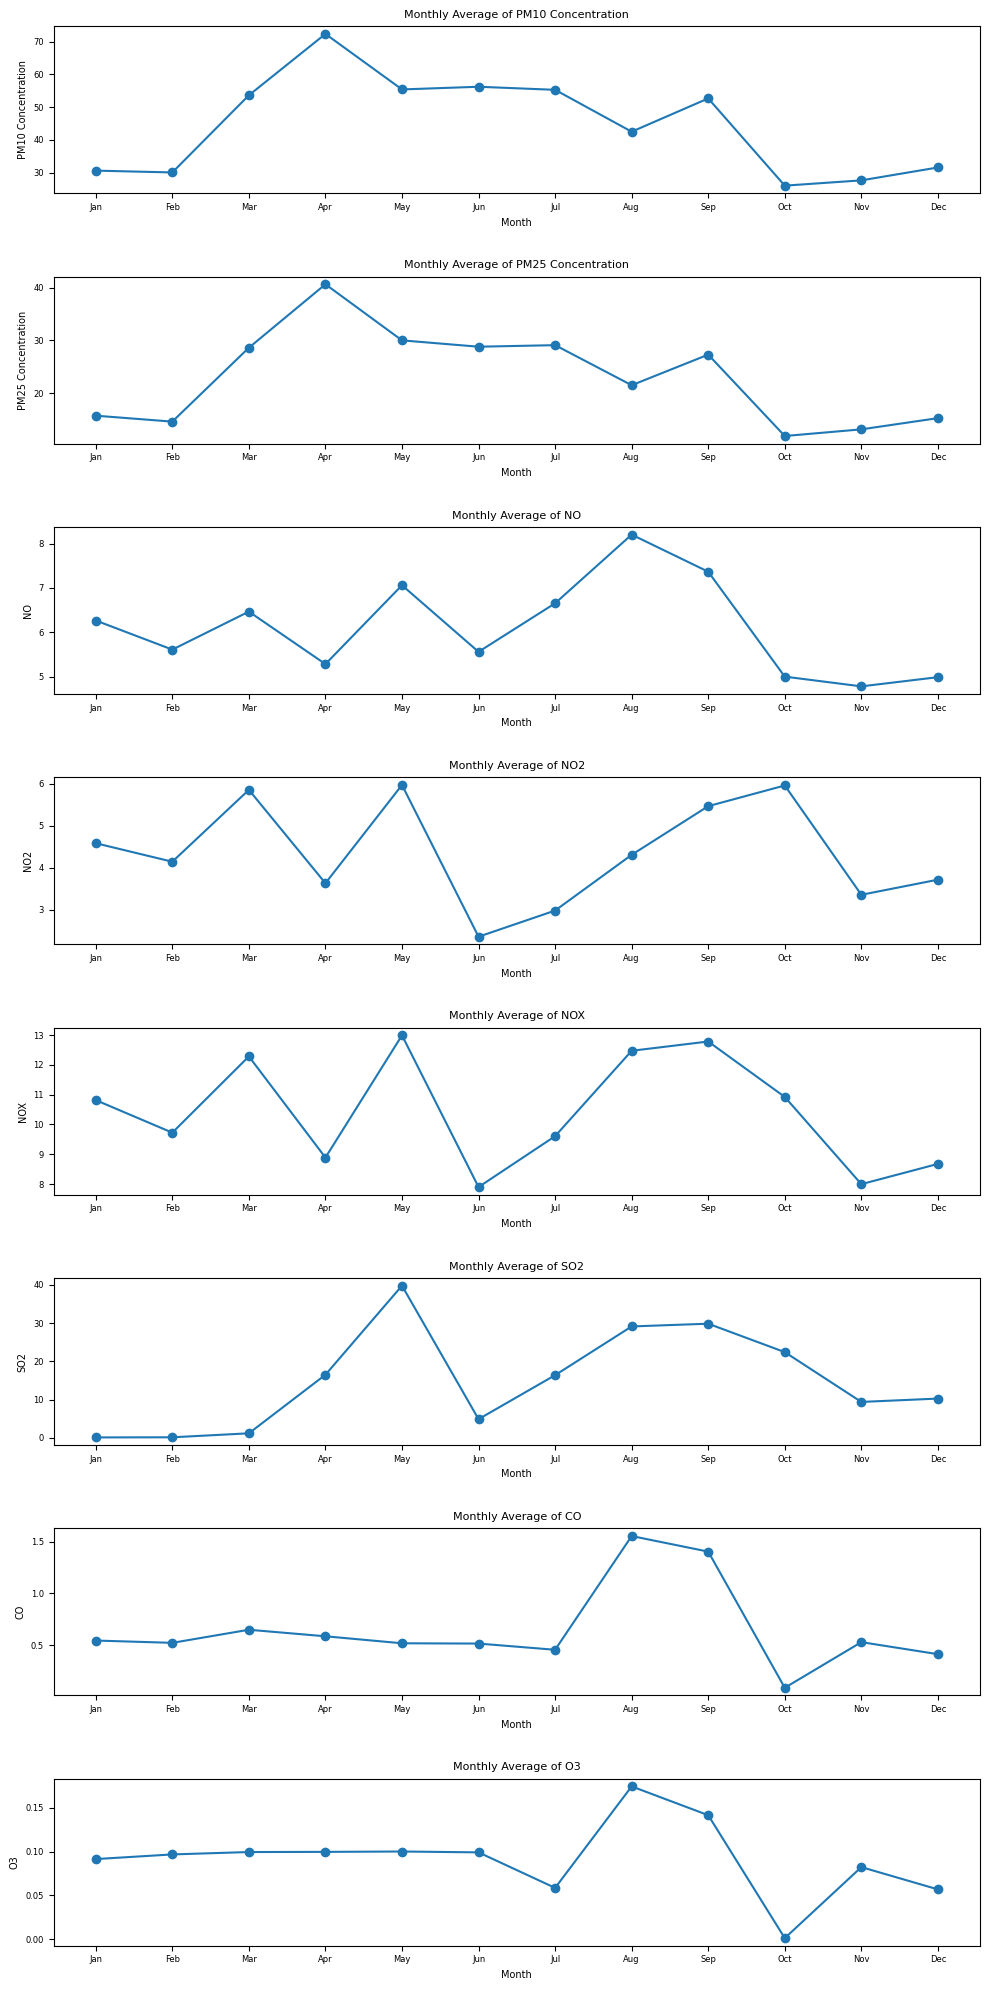

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'pandas_df' is your Pandas DataFrame and 'Month' column exists
variables = ['PM10 Concentration', 'PM25 Concentration', 'NO',
             'NO2', 'NOX', 'SO2', 'CO', 'O3']

# Convert 'Month' column to numeric if it's not already
pandas_df['Month'] = pd.to_numeric(pandas_df['Month'], errors='coerce')

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 20), dpi=100)  # Adjust figure size as needed

for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)  # One column, adjust height as needed

    # Calculate monthly averages
    monthly_avg = pandas_df.groupby('Month')[var].mean()

    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')

    plt.title(f'Monthly Average of {var}', fontsize=8)
    plt.xlabel('Month', fontsize=7)
    plt.ylabel(var, fontsize=7)

    # Set x-axis ticks to month names
    plt.xticks(range(1, 13), month_names, fontsize=6)  # Use month names for x-ticks
    plt.yticks(fontsize=6)  # Adjust y-axis tick font size

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

**Day vs. Meterological Factors**

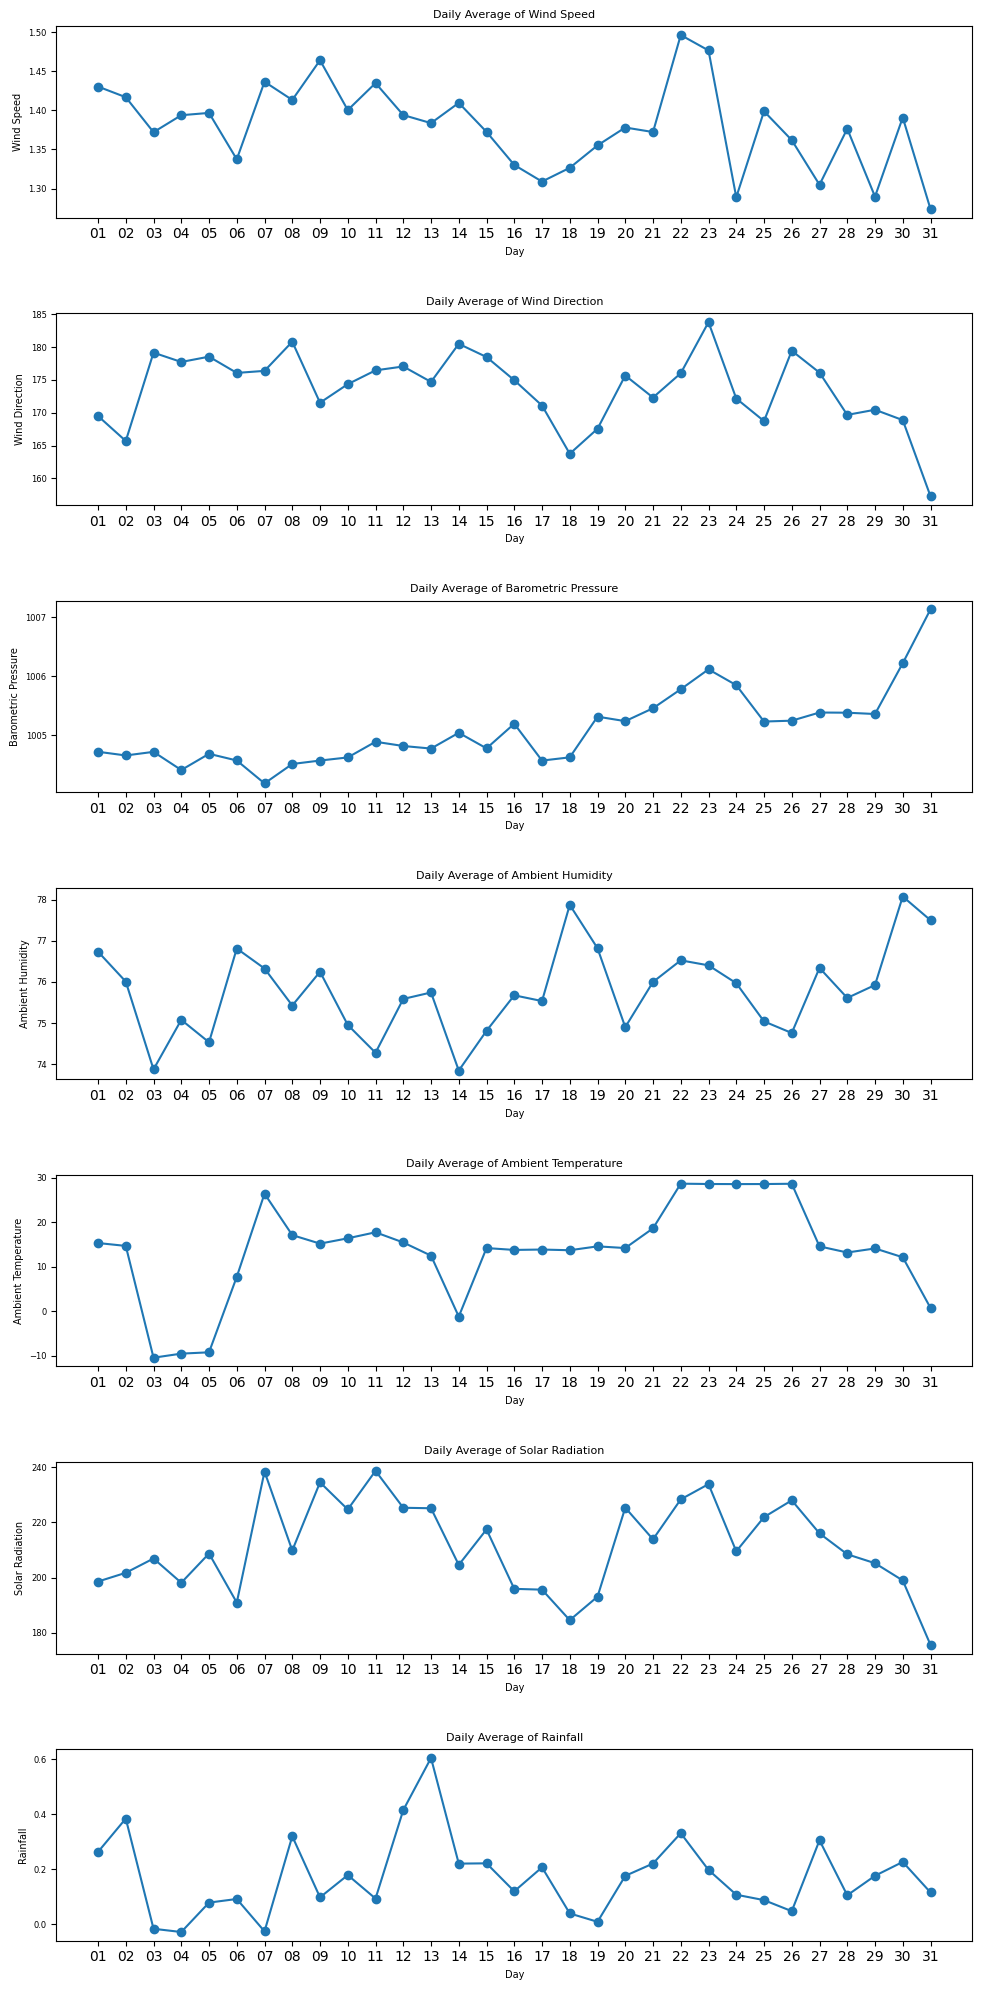

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'pandas_df' is your Pandas DataFrame and 'Month' column exists
variables = ['Wind Speed', 'Wind Direction', 'Barometric Pressure',
             'Ambient Humidity', 'Ambient Temperature', 'Solar Radiation',
             'Rainfall']

# Convert 'Month' column to numeric if it's not already
pandas_df['Month'] = pd.to_numeric(pandas_df['Day'], errors='coerce')

plt.figure(figsize=(10, 20), dpi=100)  # Adjust figure size as needed

for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)  # One column, adjust height as needed

    # Calculate monthly averages
    monthly_avg = pandas_df.groupby('Day')[var].mean()

    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')

    plt.title(f'Daily Average of {var}', fontsize=8)
    plt.xlabel('Day', fontsize=7)
    plt.ylabel(var, fontsize=7)

    plt.yticks(fontsize=6)  # Adjust y-axis tick font size

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

**Day vs. Pollutant Concentrations**

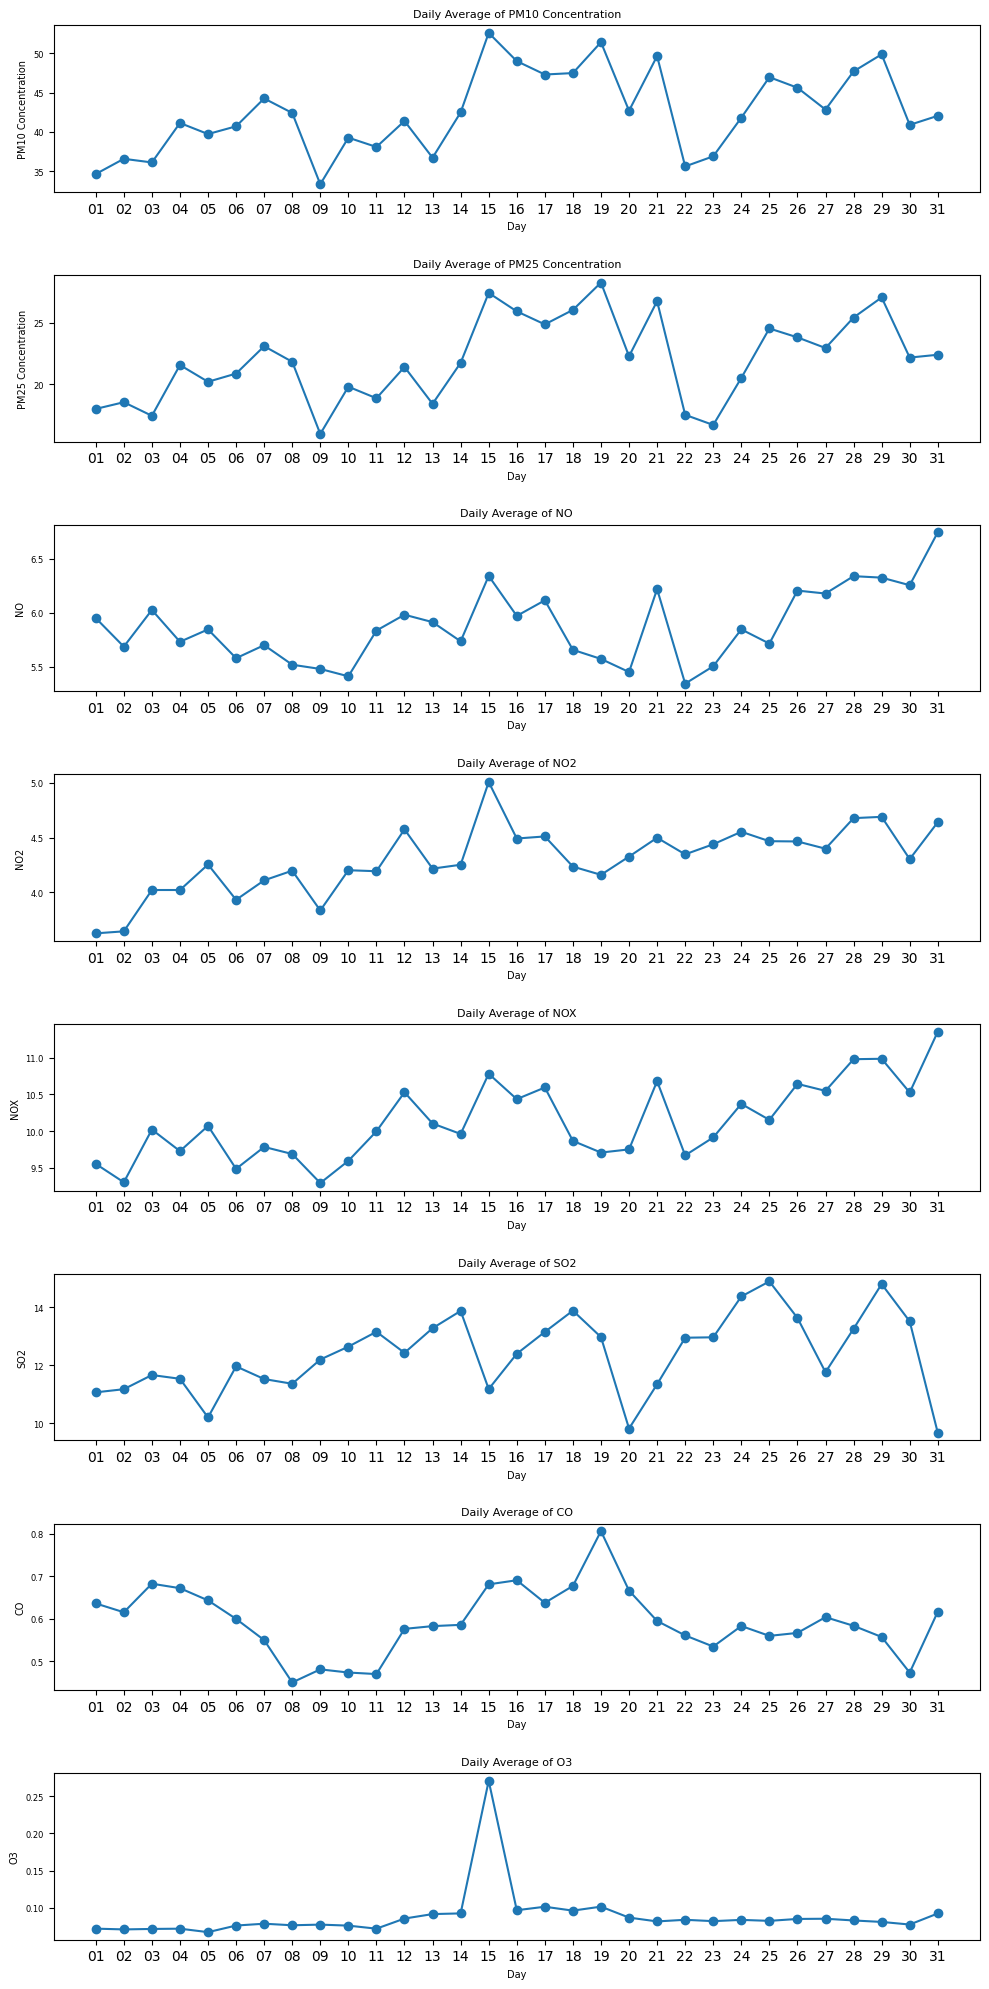

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'pandas_df' is your Pandas DataFrame and 'Month' column exists
variables = ['PM10 Concentration', 'PM25 Concentration', 'NO',
             'NO2', 'NOX', 'SO2', 'CO', 'O3']

# Convert 'Month' column to numeric if it's not already
pandas_df['Month'] = pd.to_numeric(pandas_df['Day'], errors='coerce')

plt.figure(figsize=(10, 20), dpi=100)  # Adjust figure size as needed

for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)  # One column, adjust height as needed

    # Calculate monthly averages
    monthly_avg = pandas_df.groupby('Day')[var].mean()

    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')

    plt.title(f'Daily Average of {var}', fontsize=8)
    plt.xlabel('Day', fontsize=7)
    plt.ylabel(var, fontsize=7)

    plt.yticks(fontsize=6)  # Adjust y-axis tick font size

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

**Hour vs. Meteorological Factors**

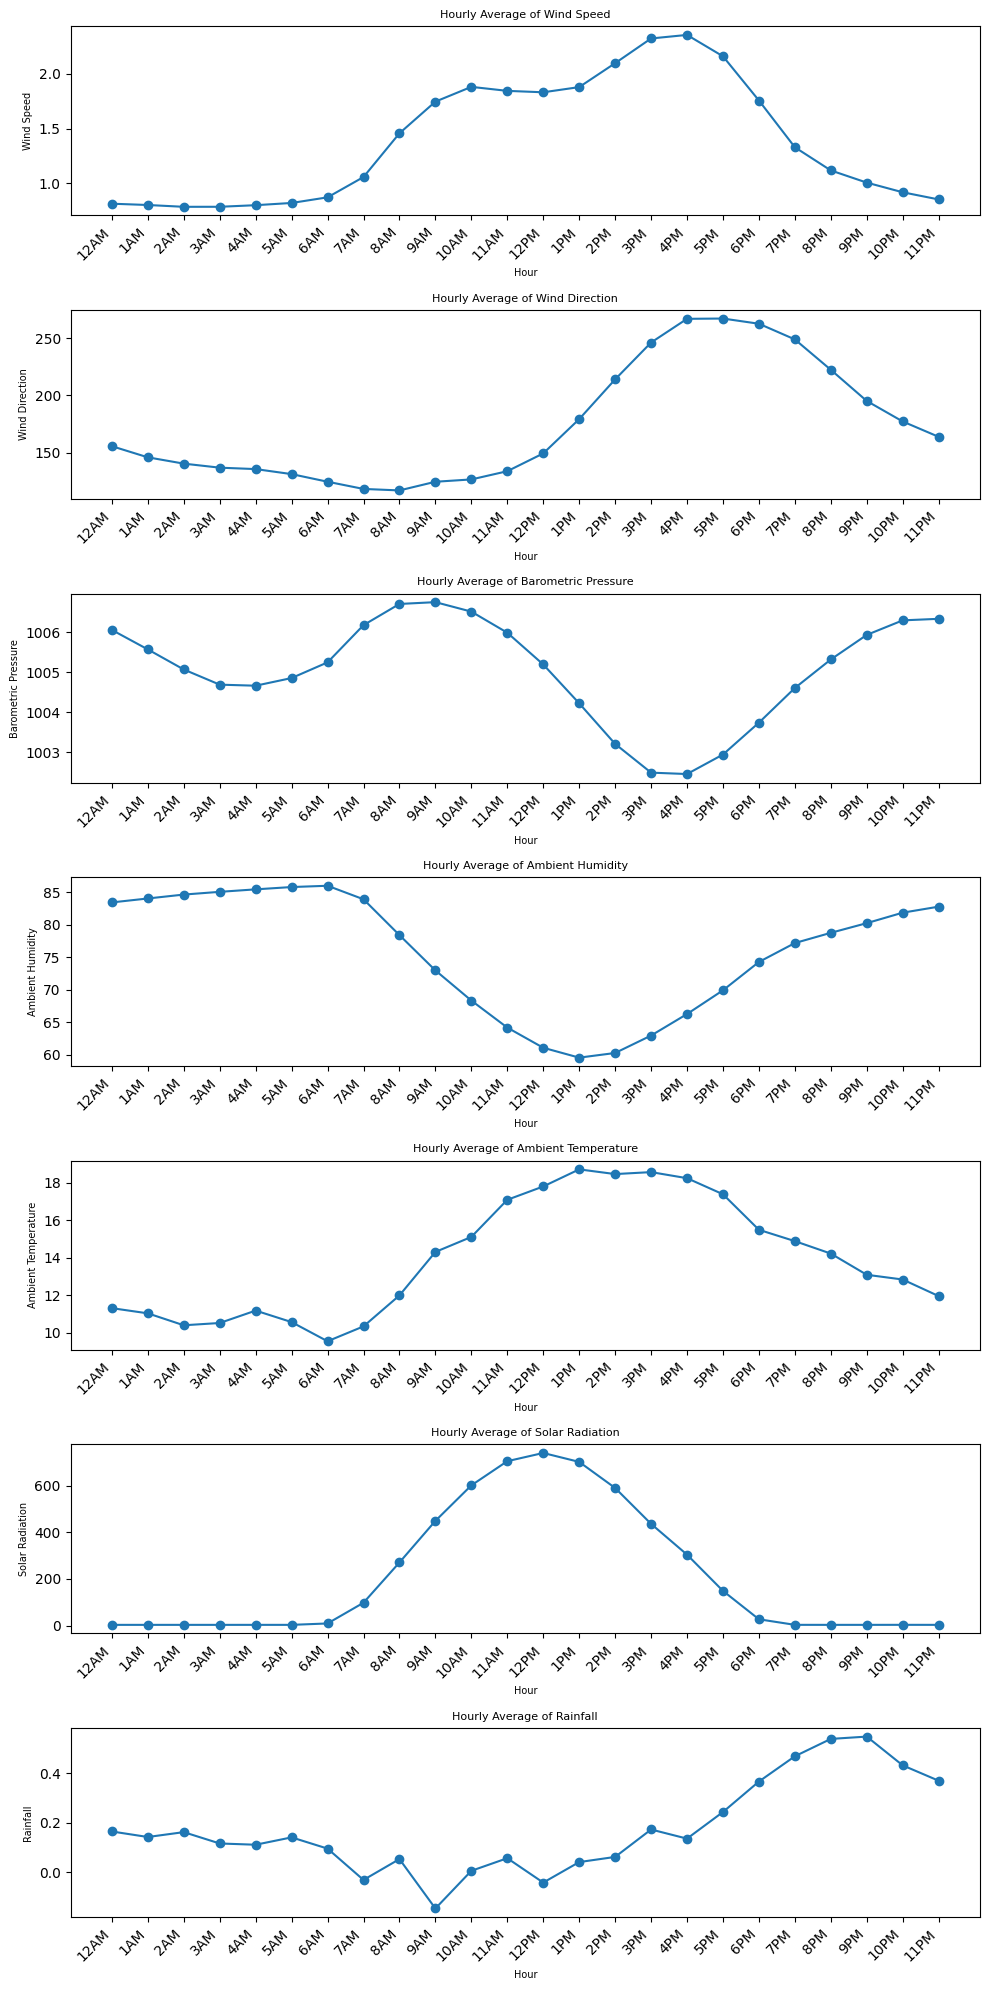

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
variables = ['Wind Speed', 'Wind Direction', 'Barometric Pressure',
             'Ambient Humidity', 'Ambient Temperature', 'Solar Radiation',
             'Rainfall']
pandas_df['Month'] = pd.to_numeric(pandas_df['Hour'], errors='coerce')

plt.figure(figsize=(10, 20), dpi=100)

for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)

    monthly_avg = pandas_df.groupby('Hour')[var].mean()

    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')

    plt.title(f'Hourly Average of {var}', fontsize=8)
    plt.xlabel('Hour', fontsize=7)
    plt.ylabel(var, fontsize=7)

    plt.xticks(
        np.arange(24),  # Assuming hours are 0-23
        [f"{h % 12 or 12}{'AM' if h < 12 else 'PM'}" for h in range(24)],
        rotation=45,  # Rotate labels 45 degrees
        ha='right'  # Align labels to the right
    )

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

**Hour vs. Pollutant Concentrations**

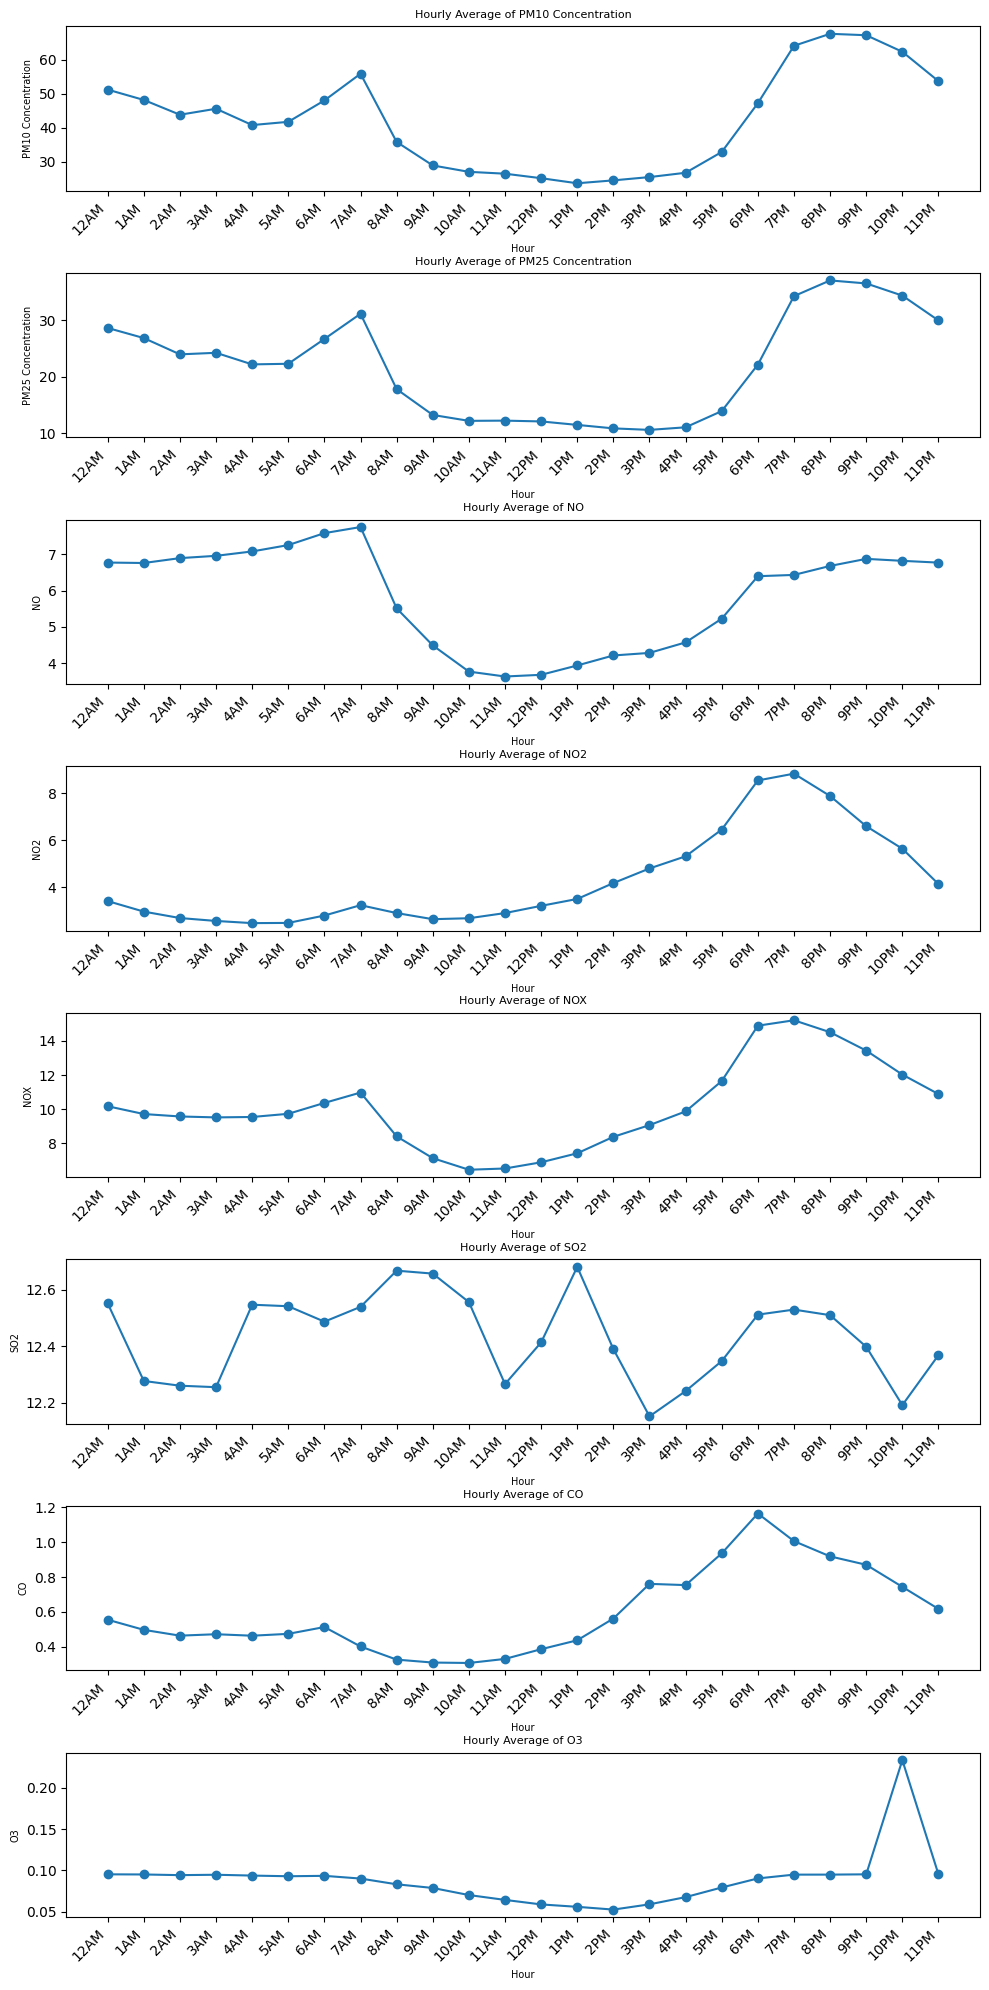

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
variables = ['PM10 Concentration', 'PM25 Concentration', 'NO',
             'NO2', 'NOX', 'SO2', 'CO', 'O3']

pandas_df['Month'] = pd.to_numeric(pandas_df['Hour'], errors='coerce')

plt.figure(figsize=(10, 20), dpi=100)

for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)

    monthly_avg = pandas_df.groupby('Hour')[var].mean()

    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')

    plt.title(f'Hourly Average of {var}', fontsize=8)
    plt.xlabel('Hour', fontsize=7)
    plt.ylabel(var, fontsize=7)

    plt.xticks(
        np.arange(24),  # Assuming hours are 0-23
        [f"{h % 12 or 12}{'AM' if h < 12 else 'PM'}" for h in range(24)],
        rotation=45,  # Rotate labels 45 degrees
        ha='right'  # Align labels to the right
    )

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

**Day of Week vs. Meteorological Factors**

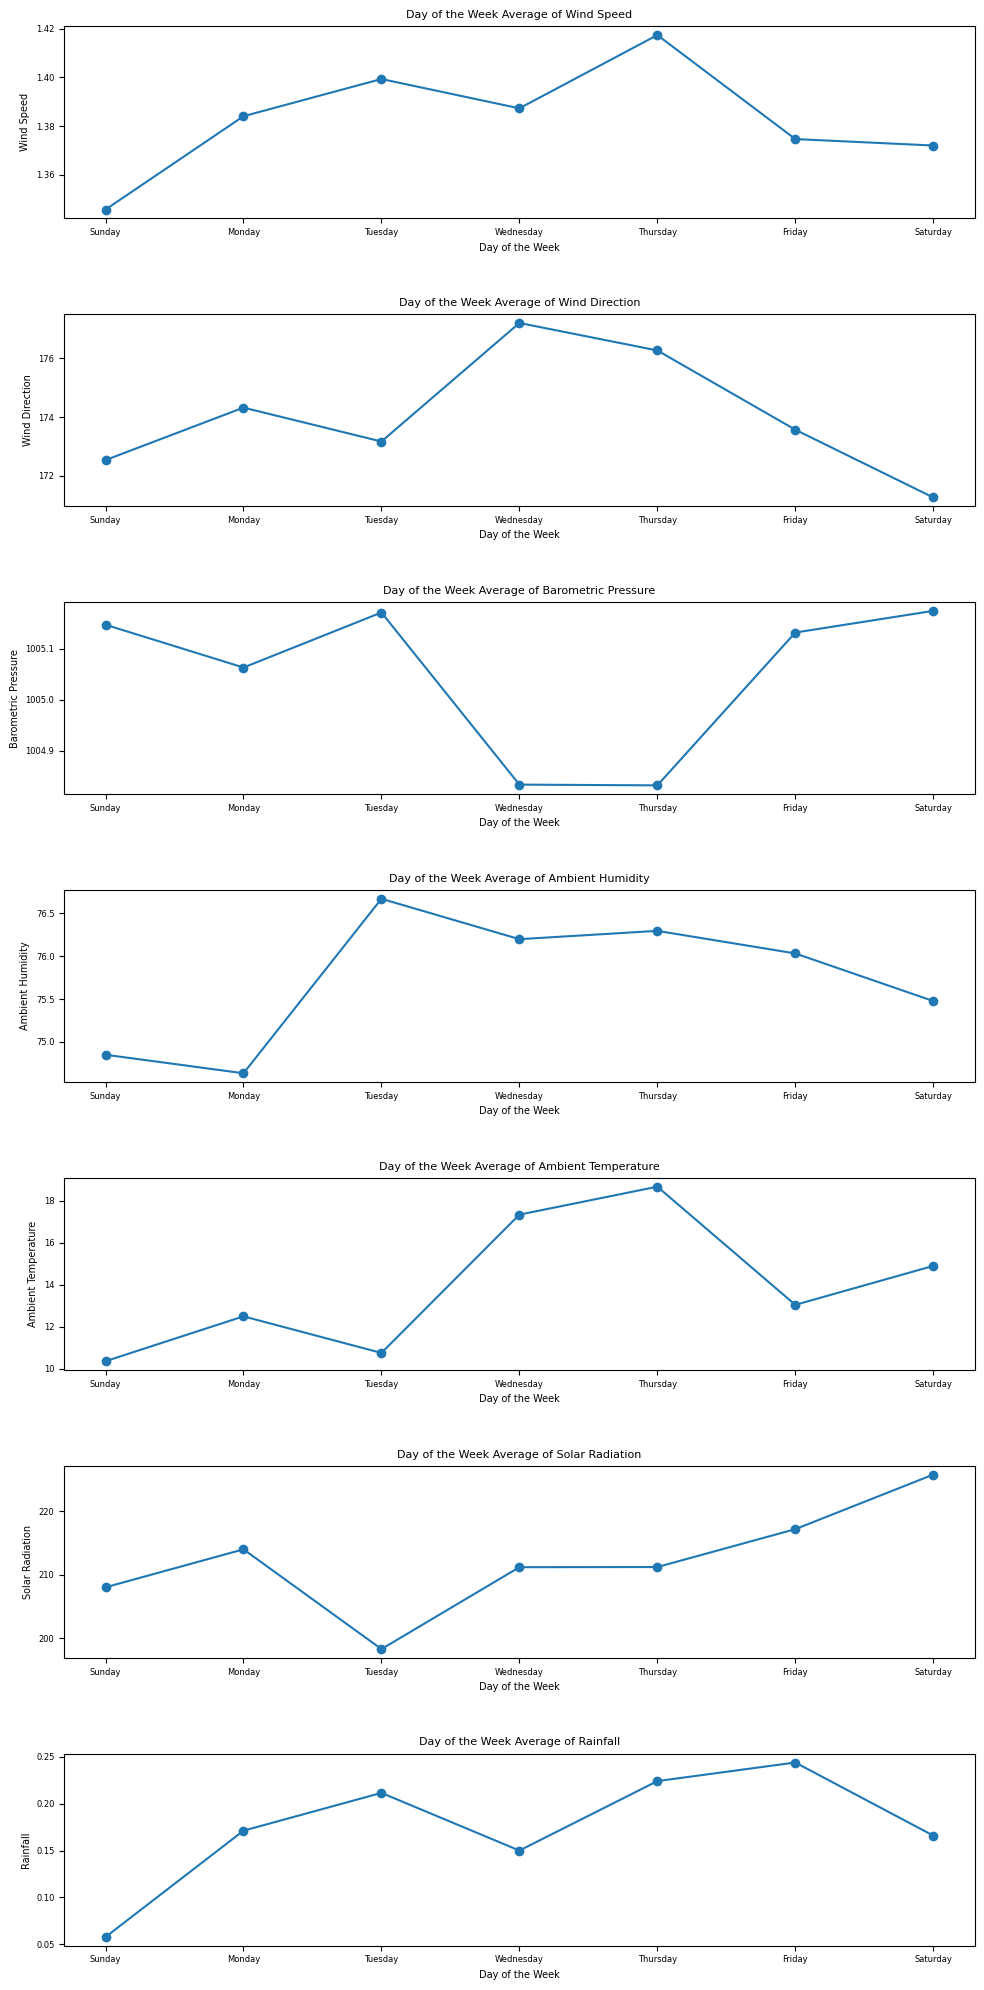

In [89]:
import matplotlib.pyplot as plt

# Assuming 'pandas_df' is your Pandas DataFrame and 'DayOfWeek' column exists
meteorological_variables = ['Wind Speed', 'Wind Direction', 'Barometric Pressure',
                            'Ambient Humidity', 'Ambient Temperature', 'Solar Radiation',
                            'Rainfall']

# Define day names in the correct order
day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

plt.figure(figsize=(10, 20), dpi=100)  # Adjust figure size as needed

for i, var in enumerate(meteorological_variables):
    plt.subplot(len(meteorological_variables), 1, i + 1)  # One column, adjust height as needed

    # Calculate daily averages for each day of the week
    daily_avg = pandas_df.groupby('DayOfWeek')[var].mean()

    # Plot the daily averages
    plt.plot(day_names, daily_avg.reindex(day_names).values, marker='o', linestyle='-')

    plt.title(f'Day of the Week Average of {var}', fontsize=8)
    plt.xlabel('Day of the Week', fontsize=7)
    plt.ylabel(var, fontsize=7)

    plt.xticks(fontsize=6)  # Use day names for x-ticks
    plt.yticks(fontsize=6)  # Adjust y-axis tick font size

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

**Day of the Week vs. Pollutant Concentrations**

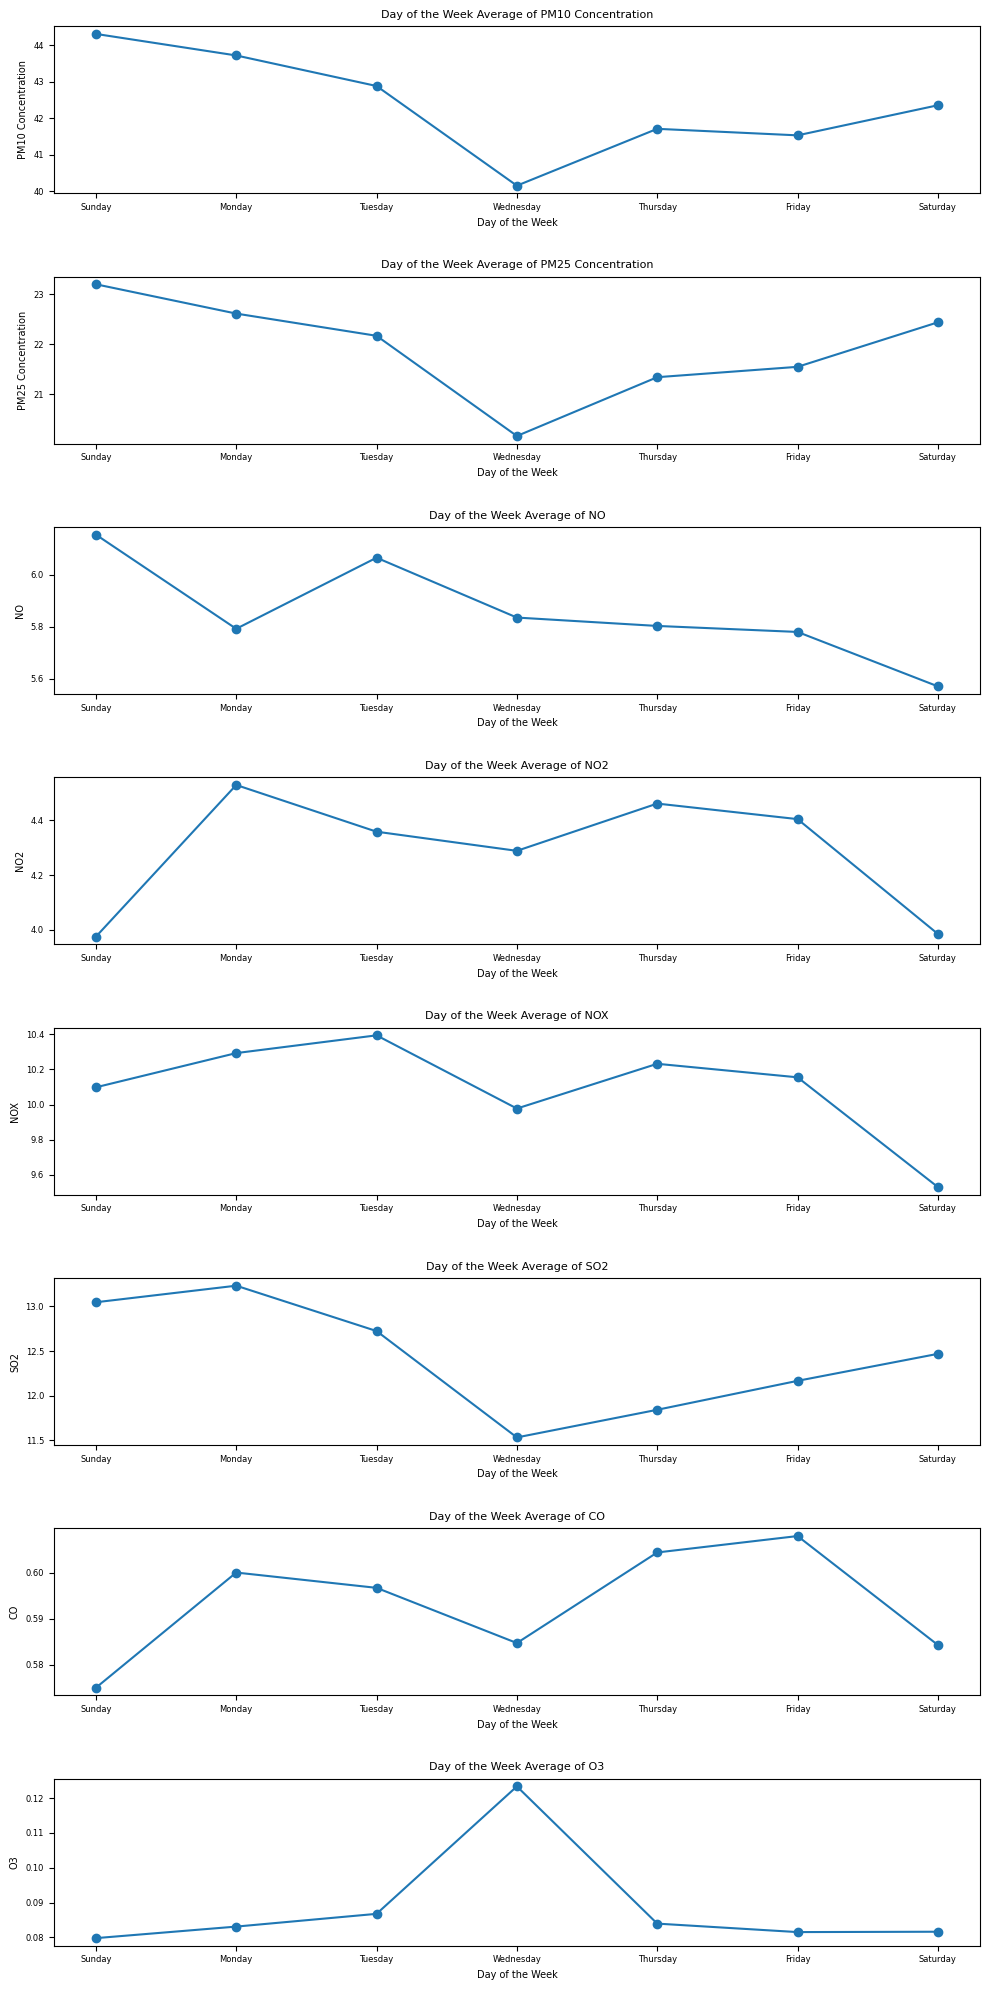

In [90]:
import matplotlib.pyplot as plt

# Assuming 'pandas_df' is your Pandas DataFrame and 'DayOfWeek' column exists
pollutant_variables = ['PM10 Concentration', 'PM25 Concentration', 'NO',
                       'NO2', 'NOX', 'SO2', 'CO', 'O3']

# Define day names in the correct order
day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

plt.figure(figsize=(10, 20), dpi=100)  # Adjust figure size as needed

for i, var in enumerate(pollutant_variables):
    plt.subplot(len(pollutant_variables), 1, i + 1)  # One column, adjust height as needed

    # Calculate daily averages for each day of the week
    daily_avg = pandas_df.groupby('DayOfWeek')[var].mean()

    # Plot the daily averages
    plt.plot(day_names, daily_avg.reindex(day_names).values, marker='o', linestyle='-')

    plt.title(f'Day of the Week Average of {var}', fontsize=8)
    plt.xlabel('Day of the Week', fontsize=7)
    plt.ylabel(var, fontsize=7)

    plt.xticks(fontsize=6)  # Use day names for x-ticks
    plt.yticks(fontsize=6)  # Adjust y-axis tick font size

    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

**Air Quality Index**

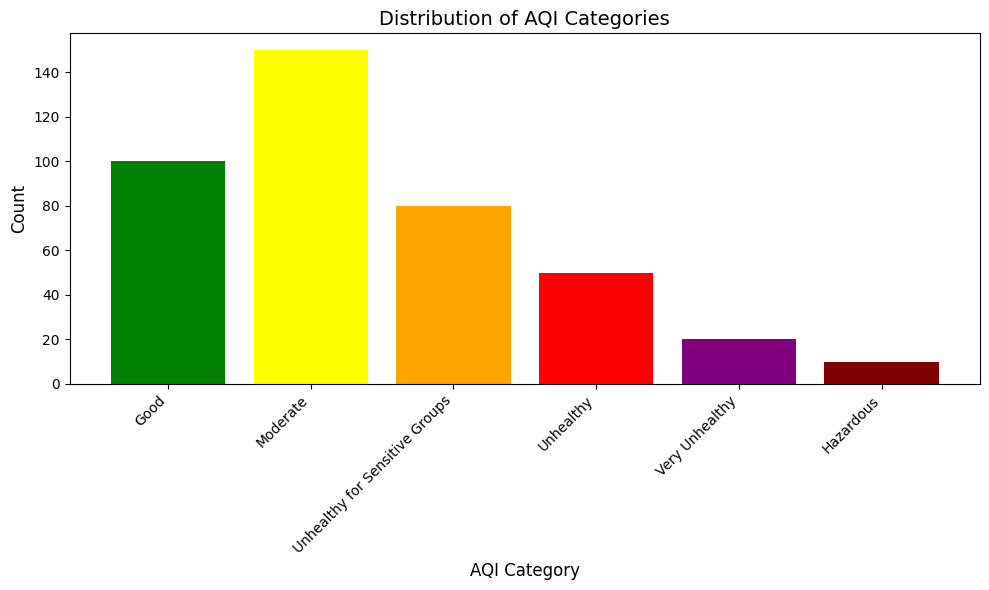

In [91]:
# prompt: generate best chart for best visualization the AQI Categories

import matplotlib.pyplot as plt
import pandas as pd

# Sample data (replace with your actual data)
data = {
    'AQI Category': ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous'],
    'Count': [100, 150, 80, 50, 20, 10] # Example counts for each category
}
df = pd.DataFrame(data)

# Bar chart for AQI Categories
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(df['AQI Category'], df['Count'], color=['green', 'yellow', 'orange', 'red', 'purple', 'maroon'])  # Customize colors
plt.xlabel('AQI Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of AQI Categories', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

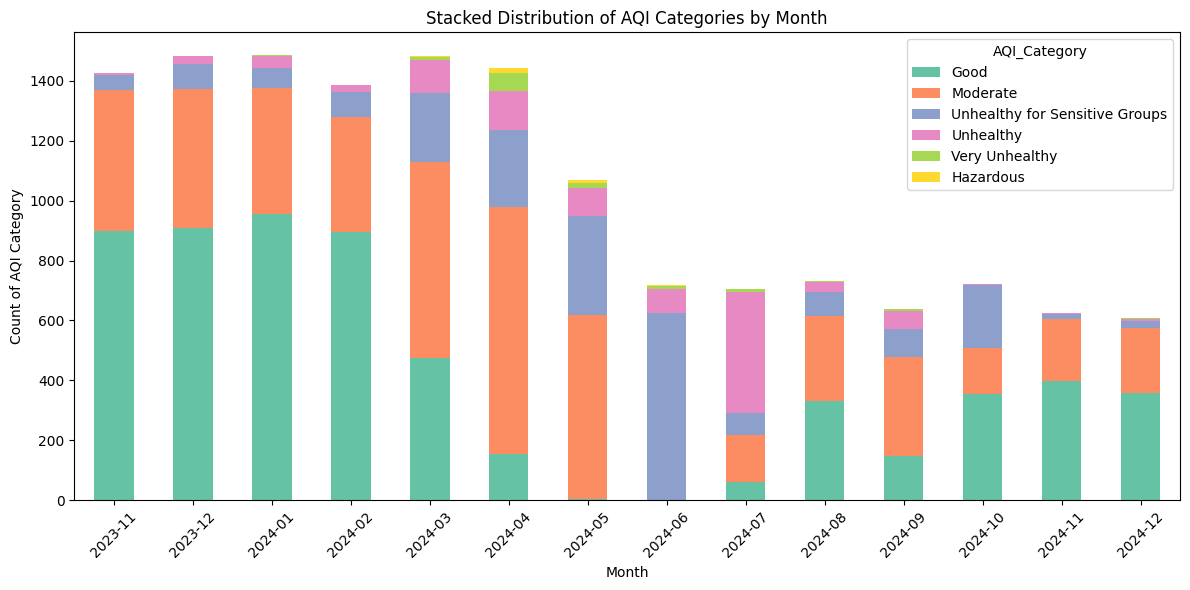

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'Date and Time' column is in datetime format
pandas_df['Date and Time'] = pd.to_datetime(pandas_df['Date and Time'], format='%d/%m/%Y %H:%M')

# Extract the month and year from 'Date and Time'
pandas_df['YearMonth'] = pandas_df['Date and Time'].dt.to_period('M')  # Creates a Period object (e.g., '2024-12')

# Get all unique AQI categories
unique_aqi_categories = pandas_df['AQI_Category'].unique()

# Group by Year-Month and AQI Category, count the occurrences
stacked_data = pandas_df.groupby(['YearMonth', 'AQI_Category']).size().unstack(fill_value=0)

# Ensure the DataFrame includes all unique AQI categories, even if they have 0 counts for some months
stacked_data = stacked_data.reindex(columns=unique_aqi_categories, fill_value=0)

# Define a pleasant color palette using Seaborn
color_palette = sns.color_palette("Set2", n_colors=len(unique_aqi_categories))

# Create a color mapping for each AQI category
aqi_colors = dict(zip(unique_aqi_categories, color_palette))

# Map colors to the AQI categories
colors = [aqi_colors.get(category, 'gray') for category in stacked_data.columns]

# Plot stacked bar chart for AQI categories per month with custom colors
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Customize the chart
plt.xlabel('Month')
plt.ylabel('Count of AQI Category')
plt.title('Stacked Distribution of AQI Categories by Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


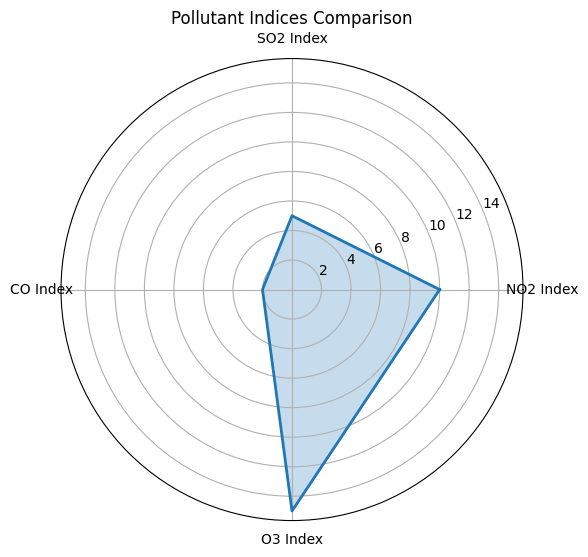

Radar Chart for AQI Category: Good


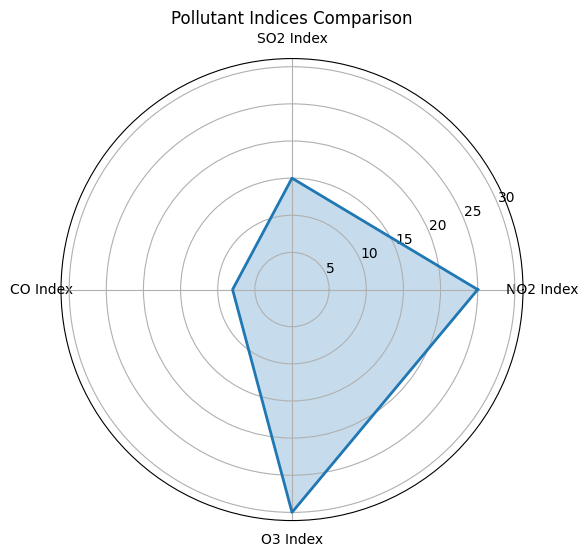

Radar Chart for AQI Category: Moderate


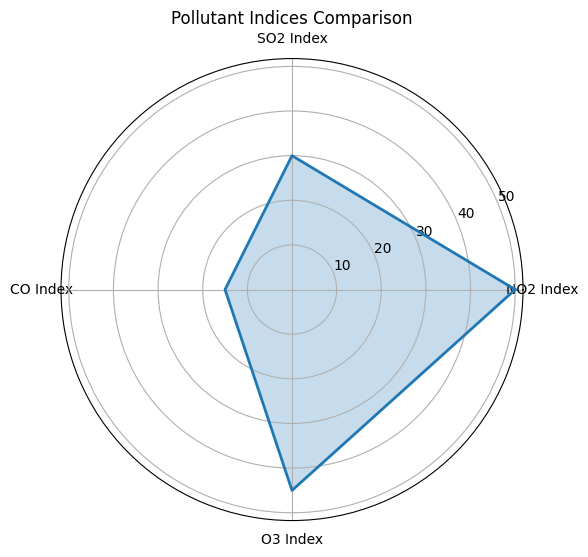

Radar Chart for AQI Category: Unhealthy for Sensitive Groups


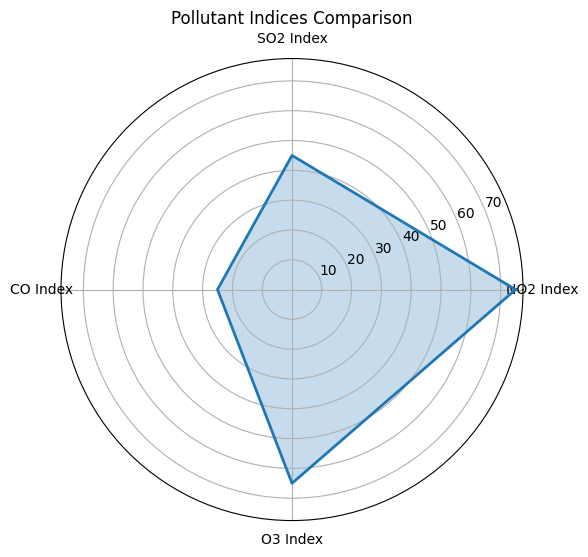

Radar Chart for AQI Category: Unhealthy


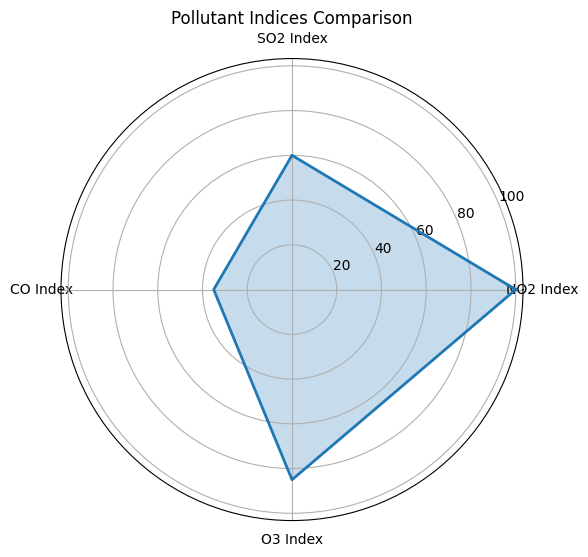

Radar Chart for AQI Category: Very Unhealthy


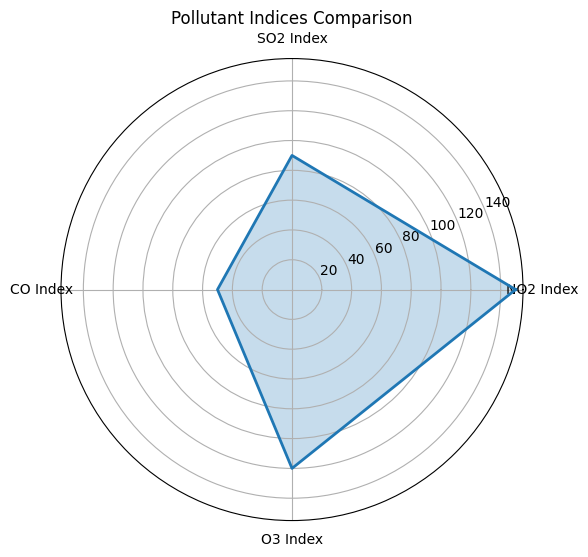

Radar Chart for AQI Category: Hazardous


In [93]:
# prompt: Radar Charts:
# For comparing pollutant indices (NO2 Index, SO2 Index, CO Index, O3 Index) across AQI Category.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data (replace with your actual data)
data = {
    'AQI Category': ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous'],
    'NO2 Index': [10, 25, 50, 75, 100, 150],
    'SO2 Index': [5, 15, 30, 45, 60, 90],
    'CO Index': [2, 8, 15, 25, 35, 50],
    'O3 Index': [15, 30, 45, 65, 85, 120]
}
df = pd.DataFrame(data)

# Function to create a radar chart
def radar_chart(df, categories, values):
    # Number of variables
    num_vars = len(categories)

    # Angles for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Close the plot
    angles += angles[:1]
    values += values[:1]

    # Create polar plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Plot data
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

    # Set axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    # Add title
    ax.set_title('Pollutant Indices Comparison')
    plt.show()

# Example usage (plotting for each AQI category)

for index, row in df.iterrows():
  categories = ['NO2 Index', 'SO2 Index', 'CO Index', 'O3 Index']
  values = [row['NO2 Index'], row['SO2 Index'], row['CO Index'], row['O3 Index']]
  radar_chart(df, categories, values)
  print(f"Radar Chart for AQI Category: {row['AQI Category']}")

**Spatial Coverage of the Cotabato City Air Quality Monitoring Station**

In [94]:
import folium
from shapely.geometry import Point
from shapely.ops import transform
from pyproj import Transformer
from shapely.geometry import mapping

# Station coordinates
latitude = 7.199751574665529
longitude = 124.24710682336072

# Function to create a buffer around the coordinates
def create_buffer(lat, lon, radius_km):
    # Create a shapely Point object for the location
    point = Point(lon, lat)

    # Define transformers for accurate buffering
    transformer_to_meters = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
    transformer_to_latlon = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)

    # Transform the point to meters (EPSG:3857)
    point_meters = transform(transformer_to_meters.transform, point)

    # Create a buffer in meters
    buffer_meters = point_meters.buffer(radius_km * 1000)  # Convert km to meters

    # Transform the buffer back to lat/lon (EPSG:4326)
    buffer_latlon = transform(transformer_to_latlon.transform, buffer_meters)

    return buffer_latlon

# Create buffers of 400m, 2km, and 5km around the point
buffer_400m = create_buffer(latitude, longitude, 0.4)
buffer_2km = create_buffer(latitude, longitude, 2)
buffer_5km = create_buffer(latitude, longitude, 5)

# Initialize a folium map centered at the station
m = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add the station marker
folium.Marker(
    location=[latitude, longitude],
    popup="Air Quality Monitoring Station",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# Add the 400m buffer
folium.GeoJson(
    mapping(buffer_400m),
    style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'fillOpacity': 0.6}
).add_to(m)

# Add the 2km buffer
folium.GeoJson(
    mapping(buffer_2km),
    style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'fillOpacity': 0.3}
).add_to(m)

# Add the 5km buffer
folium.GeoJson(
    mapping(buffer_5km),
    style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'fillOpacity': 0.1}
).add_to(m)

m.save('AQMS_buffer_map.html')
# Display the map
m

**Daily Spatio-Temporal Air Quality Index**

In [96]:
import pandas as pd
import folium
from folium.plugins import TimestampedGeoJson
from shapely.geometry import Point
from shapely.ops import transform
from pyproj import Transformer
from shapely.geometry import mapping

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Dataset/CotabatoCity_AQMS.csv')

# Ensure 'Date and Time' is in datetime format
df['Date and Time'] = pd.to_datetime(df['Date and Time'], format='%d/%m/%Y %H:%M', errors='coerce')

# Extract the date
df['Date'] = df['Date and Time'].dt.date

# Add AQI Category column if it does not exist
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

if 'AQI Category' not in df.columns:
    df['AQI Category'] = df['AQI Index'].apply(classify_aqi)

# Define AQI colors
aqi_colors = {
    'Good': 'green',
    'Moderate': 'yellow',
    'Unhealthy for Sensitive Groups': 'orange',
    'Unhealthy': 'red',
    'Very Unhealthy': 'purple',
    'Hazardous': 'maroon'
}

# Station coordinates
latitude = 7.199751574665529
longitude = 124.24710682336072

# Function to create a buffer around the coordinates
def create_buffer(lat, lon, radius_km):
    point = Point(lon, lat)
    transformer_to_meters = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
    transformer_to_latlon = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)
    point_meters = transform(transformer_to_meters.transform, point)
    buffer_meters = point_meters.buffer(radius_km * 1000)
    return transform(transformer_to_latlon.transform, buffer_meters)

# Generate GeoJSON for TimestampedGeoJson with three buffers
features = []
for date in df['Date'].unique():
    # Filter data for the current date
    daily_data = df[df['Date'] == date]

    # Determine the AQI category (use the most frequent one for the day)
    aqi_category = daily_data['AQI Category'].mode()[0]
    buffer_color = aqi_colors.get(aqi_category, 'gray')

    # Create buffers for 400m, 2km, and 5km
    buffer_400m = create_buffer(latitude, longitude, 0.4)
    buffer_2km = create_buffer(latitude, longitude, 2)
    buffer_5km = create_buffer(latitude, longitude, 5)

    # Add 400m buffer feature
    features.append({
        'type': 'Feature',
        'geometry': mapping(buffer_400m),
        'properties': {
            'time': pd.Timestamp(date).isoformat(),
            'popup': f"Date: {pd.Timestamp(date).strftime('%Y-%m-%d')}<br>AQI Category: {aqi_category}",
            'style': {
                'color': buffer_color,
                'fillColor': buffer_color,
                'fillOpacity': 0.6,
            },
        },
    })

    # Add 2km buffer feature
    features.append({
        'type': 'Feature',
        'geometry': mapping(buffer_2km),
        'properties': {
            'time': pd.Timestamp(date).isoformat(),
            'popup': f"Date: {pd.Timestamp(date).strftime('%Y-%m-%d')}<br>AQI Category: {aqi_category}",
            'style': {
                'color': buffer_color,
                'fillColor': buffer_color,
                'fillOpacity': 0.3,
            },
        },
    })

    # Add 5km buffer feature
    features.append({
        'type': 'Feature',
        'geometry': mapping(buffer_5km),
        'properties': {
            'time': pd.Timestamp(date).isoformat(),
            'popup': f"Date: {pd.Timestamp(date).strftime('%Y-%m-%d')}<br>AQI Category: {aqi_category}",
            'style': {
                'color': buffer_color,
                'fillColor': buffer_color,
                'fillOpacity': 0.1,
            },
        },
    })

geojson_data = {
    'type': 'FeatureCollection',
    'features': features,
}

# Initialize the map
m = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add TimestampedGeoJson for AQI data
TimestampedGeoJson(
    geojson_data,
    period='P1D',  # Daily intervals
    add_last_point=True,
    auto_play=True,
    loop=True,
    duration='P1D',  # Ensure previous buffers disappear when time passes
).add_to(m)

# Add a legend
legend_html = """
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 200px; height: 300px;
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
<h4>AQI Categories</h4>
<ul style="list-style-type:none; padding:0;">
    <li><span style="background:green; width:10px; height:10px; display:inline-block;"></span> Good</li>
    <li><span style="background:yellow; width:10px; height:10px; display:inline-block;"></span> Moderate</li>
    <li><span style="background:orange; width:10px; height:10px; display:inline-block;"></span> Unhealthy for Sensitive Groups</li>
    <li><span style="background:red; width:10px; height:10px; display:inline-block;"></span> Unhealthy</li>
    <li><span style="background:purple; width:10px; height:10px; display:inline-block;"></span> Very Unhealthy</li>
    <li><span style="background:maroon; width:10px; height:10px; display:inline-block;"></span> Hazardous</li>
</ul>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save or display the map
m.save('daily_spatio_temporal_aqi_map.html')
m

In [97]:
pip install pandas dash plotly


In [98]:
!python app.py

python3: can't open file '/content/app.py': [Errno 2] No such file or directory


**Meteorological Factors Dropdown**

In [100]:
import pandas as pd
import plotly.graph_objects as go

# Load your dataset (replace with your actual dataset)
df = pd.read_csv('/content/drive/MyDrive/Dataset/CotabatoCity_AQMS.csv')

# Ensure 'Date and Time' is in datetime format
df['Date and Time'] = pd.to_datetime(df['Date and Time'], format='%d/%m/%Y %H:%M', dayfirst=True, errors='coerce')

# Extract additional time-based features
df['Month'] = df['Date and Time'].dt.month
df['Day'] = df['Date and Time'].dt.day
df['Hour'] = df['Date and Time'].dt.hour
df['DayOfWeek'] = df['Date and Time'].dt.day_name()

# List of meteorological factors
meteorological_factors = ['Wind Speed', 'Wind Direction', 'Barometric Pressure',
                          'Ambient Humidity', 'Ambient Temperature', 'Solar Radiation', 'Rainfall']

# Create a plotly figure
fig = go.Figure()

# Add traces for each meteorological factor with default aggregation (e.g., Monthly)
for factor in meteorological_factors:
    agg_df = df.groupby('Month')[factor].mean().reset_index()
    fig.add_trace(
        go.Scatter(
            x=agg_df['Month'],
            y=agg_df[factor],
            mode='lines+markers',
            name=factor
        )
    )

# Add dropdown for selecting aggregation type
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": "Monthly",
                    "method": "update",
                    "args": [
                        {
                            "x": [df.groupby('Month')[factor].mean().reset_index()['Month'] for factor in meteorological_factors],
                            "y": [df.groupby('Month')[factor].mean().reset_index()[factor] for factor in meteorological_factors]
                        },
                        {"title": "Trends of Meteorological Factors by Month"}
                    ],
                },
                {
                    "label": "Daily",
                    "method": "update",
                    "args": [
                        {
                            "x": [df.groupby('Day')[factor].mean().reset_index()['Day'] for factor in meteorological_factors],
                            "y": [df.groupby('Day')[factor].mean().reset_index()[factor] for factor in meteorological_factors]
                        },
                        {"title": "Trends of Meteorological Factors by Day"}
                    ],
                },
                {
                    "label": "Hourly",
                    "method": "update",
                    "args": [
                        {
                            "x": [df.groupby('Hour')[factor].mean().reset_index()['Hour'] for factor in meteorological_factors],
                            "y": [df.groupby('Hour')[factor].mean().reset_index()[factor] for factor in meteorological_factors]
                        },
                        {"title": "Trends of Meteorological Factors by Hour"}
                    ],
                },
                {
                    "label": "Day of Week",
                    "method": "update",
                    "args": [
                        {
                            "x": [df.groupby('DayOfWeek')[factor].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()['DayOfWeek'] for factor in meteorological_factors],
                            "y": [df.groupby('DayOfWeek')[factor].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()[factor] for factor in meteorological_factors]
                        },
                        {"title": "Trends of Meteorological Factors by Day of Week"}
                    ],
                },
            ],
            "direction": "down",
        }
    ],
    title="Trends of Meteorological Factors",
    xaxis_title="Time",
    yaxis_title="Values",
    template='plotly'
)

# Save the figure as an HTML file
fig.write_html("meteorological_trends_with_dropdown.html", auto_open=True)

**Pollutant Concentration Dropdown**

In [101]:
import pandas as pd
import plotly.graph_objects as go

# Load your dataset (replace with your actual dataset)
df = pd.read_csv('/content/drive/MyDrive/Dataset/CotabatoCity_AQMS.csv')

# Ensure 'Date and Time' is in datetime format
df['Date and Time'] = pd.to_datetime(df['Date and Time'], format='%d/%m/%Y %H:%M', dayfirst=True)

# Extract additional time-based features
df['Month'] = df['Date and Time'].dt.month
df['Day'] = df['Date and Time'].dt.day
df['Hour'] = df['Date and Time'].dt.hour
df['DayOfWeek'] = df['Date and Time'].dt.day_name()

# List of pollutant concentrations
pollutant_concentrations = ['PM10 Concentration', 'PM25 Concentration', 'NO',
                            'NO2', 'NOX', 'SO2', 'CO', 'O3']

# Create figure
fig = go.Figure()

# Add traces for each pollutant concentration by default (e.g., by Month)
for pollutant in pollutant_concentrations:
    agg_df = df.groupby('Month')[pollutant].mean().reset_index()
    fig.add_trace(
        go.Scatter(
            x=agg_df['Month'],
            y=agg_df[pollutant],
            mode='lines+markers',
            name=pollutant
        )
    )

# Update layout with dropdown
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": "Monthly",
                    "method": "update",
                    "args": [
                        {
                            "x": [df.groupby('Month')[p].mean().reset_index()['Month'] for p in pollutant_concentrations],
                            "y": [df.groupby('Month')[p].mean().reset_index()[p] for p in pollutant_concentrations]
                        },
                        {"title": "Pollutant Concentrations by Month"}
                    ],
                },
                {
                    "label": "Daily",
                    "method": "update",
                    "args": [
                        {
                            "x": [df.groupby('Day')[p].mean().reset_index()['Day'] for p in pollutant_concentrations],
                            "y": [df.groupby('Day')[p].mean().reset_index()[p] for p in pollutant_concentrations]
                        },
                        {"title": "Pollutant Concentrations by Day"}
                    ],
                },
                {
                    "label": "Hourly",
                    "method": "update",
                    "args": [
                        {
                            "x": [df.groupby('Hour')[p].mean().reset_index()['Hour'] for p in pollutant_concentrations],
                            "y": [df.groupby('Hour')[p].mean().reset_index()[p] for p in pollutant_concentrations]
                        },
                        {"title": "Pollutant Concentrations by Hour"}
                    ],
                },
                {
                    "label": "Day of Week",
                    "method": "update",
                    "args": [
                        {
                            "x": [df.groupby('DayOfWeek')[p].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()['DayOfWeek'] for p in pollutant_concentrations],
                            "y": [df.groupby('DayOfWeek')[p].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()[p] for p in pollutant_concentrations]
                        },
                        {"title": "Pollutant Concentrations by Day of Week"}
                    ],
                }
            ],
            "direction": "down",
        }
    ],
    title="Pollutant Concentrations by Time Granularity",
    xaxis_title="Time",
    yaxis_title="Concentration",
)

# Save to HTML
fig.write_html("pollutant_concentration_trends_with_dropdown.html", auto_open=True)


**Cotabato City Air Quality Monitoring Station Dashboard**

In [108]:
import pandas as pd
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import TimestampedGeoJson
from shapely.geometry import Point
from shapely.ops import transform
from pyproj import Transformer
from shapely.geometry import mapping

# Load dataset (replace with your actual dataset)
df = pd.read_csv('/content/drive/MyDrive/Dataset/CotabatoCity_AQMS.csv')

# Ensure 'Date and Time' is in datetime format
df['Date and Time'] = pd.to_datetime(df['Date and Time'])

# Extract additional time-based features
df['Month'] = df['Date and Time'].dt.month
df['Day'] = df['Date and Time'].dt.day
df['Hour'] = df['Date and Time'].dt.hour
df['DayOfWeek'] = df['Date and Time'].dt.day_name()
df['Date'] = df['Date and Time'].dt.date  # Extract only the date

# List of meteorological factors
meteorological_factors = ['Wind Speed', 'Wind Direction', 'Barometric Pressure',
                          'Ambient Humidity', 'Ambient Temperature', 'Solar Radiation', 'Rainfall']

# List of pollutant concentrations
pollutant_concentrations = ['PM10 Concentration', 'PM25 Concentration', 'NO',
                            'NO2', 'NOX', 'SO2', 'CO', 'O3']

# Classify AQI into categories
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

df['AQI Category'] = df['AQI Index'].apply(classify_aqi)

# Define AQI colors
aqi_colors = {
    'Good': 'green',
    'Moderate': 'yellow',
    'Unhealthy for Sensitive Groups': 'orange',
    'Unhealthy': 'red',
    'Very Unhealthy': 'purple',
    'Hazardous': 'maroon'
}

# Initialize Dash app
app = dash.Dash(__name__)

# Layout for the dashboard
app.layout = html.Div([
    html.H1("Air Quality Monitoring Dashboard", style={'text-align': 'center'}),

    # Section 1: Spatio-Temporal Visualization
    html.Div([
        html.H2("1. Spatio-Temporal Visualization"),
        dcc.Slider(
            id='date-slider',
            min=df['Date'].min().toordinal(),
            max=df['Date'].max().toordinal(),
            value=df['Date'].min().toordinal(),
            marks={date.toordinal(): date.strftime('%Y-%m-%d') for date in pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='M').date},
            step=1
        ),
        html.Iframe(id='spatio-temporal-map', width='100%', height='600px')
    ], style={'margin-bottom': '50px'}),

    # Section 2: Meteorological Factor Trends
    html.Div([
        html.H2("2. Meteorological Factor Trends"),
        dcc.Dropdown(
            id='meteorological-time-dropdown',
            options=[{'label': 'Monthly', 'value': 'Month'},
                     {'label': 'Daily', 'value': 'Day'},
                     {'label': 'Hourly', 'value': 'Hour'},
                     {'label': 'Day of Week', 'value': 'DayOfWeek'}],
            value='Month',
            clearable=False
        ),
        dcc.Graph(id='meteorological-trend-graph')
    ], style={'margin-bottom': '50px'}),

    # Section 3: Pollutant Concentration Trends
    html.Div([
        html.H2("3. Pollutant Concentration Trends"),
        dcc.Dropdown(
            id='pollutant-time-dropdown',
            options=[{'label': 'Monthly', 'value': 'Month'},
                     {'label': 'Daily', 'value': 'Day'},
                     {'label': 'Hourly', 'value': 'Hour'},
                     {'label': 'Day of Week', 'value': 'DayOfWeek'}],
            value='Month',
            clearable=False
        ),
        dcc.Graph(id='pollutant-trend-graph')
    ])
])

# Callback for Spatio-Temporal Visualization
@app.callback(
    Output('spatio-temporal-map', 'srcDoc'),
    Input('date-slider', 'value')
)
def update_map(selected_date):
    # Convert the slider value to a date
    selected_date = pd.Timestamp.fromordinal(selected_date).date()
    selected_data = df[df['Date'] == selected_date]

    # Initialize map
    latitude, longitude = 7.199751574665529, 124.24710682336072
    m = folium.Map(location=[latitude, longitude], zoom_start=12)

    # Add AQI legend
    legend_html = """
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 200px; height: 200px;
                background-color: white; z-index:9999; font-size:14px;
                border:2px solid grey; padding: 10px;">
    <h4>AQI Categories</h4>
    <ul style="list-style-type:none; padding:0;">
        <li><span style="background:green; width:10px; height:10px; display:inline-block;"></span> Good</li>
        <li><span style="background:yellow; width:10px; height:10px; display:inline-block;"></span> Moderate</li>
        <li><span style="background:orange; width:10px; height:10px; display:inline-block;"></span> Unhealthy for Sensitive Groups</li>
        <li><span style="background:red; width:10px; height:10px; display:inline-block;"></span> Unhealthy</li>
        <li><span style="background:purple; width:10px; height:10px; display:inline-block;"></span> Very Unhealthy</li>
        <li><span style="background:maroon; width:10px; height:10px; display:inline-block;"></span> Hazardous</li>
    </ul>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    # Handle case where no data is found for the selected date
    if selected_data.empty:
        folium.Marker(location=[latitude, longitude], popup="No data available").add_to(m)
    else:
        aqi_category = selected_data['AQI Category'].iloc[0]
        buffer_color = aqi_colors.get(aqi_category, 'gray')

        # Function to create buffers
        def create_buffer(lat, lon, radius_km):
            point = Point(lon, lat)
            transformer_to_meters = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
            transformer_to_latlon = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)
            point_meters = transform(transformer_to_meters.transform, point)
            buffer_meters = point_meters.buffer(radius_km * 1000)
            return transform(transformer_to_latlon.transform, buffer_meters)

        # Add buffers
        for radius, opacity in [(0.4, 0.6), (2, 0.3), (5, 0.1)]:
            buffer = create_buffer(latitude, longitude, radius)
            folium.GeoJson(
                mapping(buffer),
                style_function=lambda x: {'fillColor': buffer_color,
                                          'color': buffer_color,
                                          'fillOpacity': opacity}
            ).add_to(m)

        # Add parameters as a popup
        params = selected_data[meteorological_factors + pollutant_concentrations].iloc[0].to_dict()
        param_popup = "<br>".join([f"<b>{k}:</b> {v}" for k, v in params.items()])
        folium.Popup(param_popup, max_width=300).add_to(m)

    # Save to HTML and read content
    m.save('temp_map.html')
    with open('temp_map.html', 'r') as f:
        return f.read()

# Callback for Meteorological Trends
@app.callback(
    Output('meteorological-trend-graph', 'figure'),
    Input('meteorological-time-dropdown', 'value')
)
def update_meteorological_graph(selected_granularity):
    fig = make_subplots(
        rows=len(meteorological_factors), cols=1,
        shared_xaxes=True, vertical_spacing=0.03,
        subplot_titles=meteorological_factors
    )
    for i, factor in enumerate(meteorological_factors):
        agg_df = df.groupby(selected_granularity)[factor].mean().reset_index()
        fig.add_trace(
            go.Scatter(x=agg_df[selected_granularity], y=agg_df[factor], mode='lines+markers'),
            row=i + 1, col=1
        )
    fig.update_layout(height=400 * len(meteorological_factors), showlegend=False, title=f"Trends by {selected_granularity}")
    return fig

# Callback for Pollutant Concentration Trends
@app.callback(
    Output('pollutant-trend-graph', 'figure'),
    Input('pollutant-time-dropdown', 'value')
)
def update_pollutant_graph(selected_granularity):
    fig = make_subplots(
        rows=len(pollutant_concentrations), cols=1,
        shared_xaxes=True, vertical_spacing=0.03,
        subplot_titles=pollutant_concentrations
    )
    for i, pollutant in enumerate(pollutant_concentrations):
        agg_df = df.groupby(selected_granularity)[pollutant].mean().reset_index()
        fig.add_trace(
            go.Scatter(x=agg_df[selected_granularity], y=agg_df[pollutant], mode='lines+markers'),
            row=i + 1, col=1
        )
    fig.update_layout(height=400 * len(pollutant_concentrations), showlegend=False, title=f"Trends by {selected_granularity}")
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

<ipython-input-108-86dbc36919d8>:18: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

<ipython-input-108-86dbc36919d8>:77: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



<IPython.core.display.Javascript object>